In [1]:
import pandas as pd
from tqdm import tqdm, tqdm_pandas
import glob
import os
import time
import ast
import numpy as np
import pickle
import h5py
from sktime.forecasting.ets import AutoETS
import sklearn.metrics as metrics
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as mticker
tqdm.pandas()

In [ ]:
START_POI = 0
END_POI = 450
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

In [2]:
def get_merged_df(csv_path,num=2000):

    start = time.time()
    merge_df = pd.read_csv(csv_path)
    print(merge_df.shape)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.head(num)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))


    end = time.time()
    print("pass {}".format(end-start))

    return merge_df

poi_db = load_poi_db()


core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


In [3]:
poi_db

safegraph_place_id  \
0      sg:0384a9b4871044909989630eb9ce0fd9   
1      sg:1e2211843ce241b789cf14ec35d0b72b   
2      sg:1f37c00efa7543d5ab550c0dedce0265   
3      sg:2601f87f98364a18899638498633ddf8   
4      sg:28e232639d884eca8dff56e57ddf6329   
...                                    ...   
43568  sg:d987378fe9e44ccea55dd3c7c30d6fda   
43569  sg:ddf672ef05f649829d1ed0c433fa72cd   
43570  sg:e4f295734d264a31987e8ab06e533278   
43571  sg:e565410a4d064627af60a229af61a916   
43572  sg:f54b59fb14374441a2333965ce698906   

                 parent_safegraph_place_id               location_name  \
0      sg:0272f8ff494d464da41479b2c2e4ab70  Altar'd Interiors Pearland   
1                                      NaN        The French Fry House   
2                                      NaN              Blue Fox Farms   
3                                      NaN         Exclusive Furniture   
4                                      NaN       South Post Oak Texaco   
...                                    ...                         ...   
43568                                  NaN  H Town Smoke And Vape Shop   
43569                                  NaN                Regions Bank   
43570                                  NaN             Cathy Home Care   
43571                                  NaN               Valero Energy   
43572                                  NaN              Tu Casa Realty   

                             safegraph_brand_ids         brands  \
0                                            NaN            NaN   
1                                            NaN            NaN   
2                                            NaN            NaN   
3                                            NaN            NaN   
4                                            NaN            NaN   
...                                          ...            ...   
43568                                        NaN            NaN   
43569  SG_BRAND_fdb30999f82136215abf97c7bd020043   Regions Bank   
43570                                        NaN            NaN   
43571  SG_BRAND_efcbcd9984a46b4d7bed503b4ac5bc95  Valero Energy   
43572                                        NaN            NaN   

                                       top_category  \
0                                  Furniture Stores   
1               Restaurants and Other Eating Places   
2      Office Supplies, Stationery, and Gift Stores   
3                                  Furniture Stores   
4                                 Gasoline Stations   
...                                             ...   
43568           Other Miscellaneous Store Retailers   
43569              Depository Credit Intermediation   
43570                     Home Health Care Services   
43571                             Gasoline Stations   
43572              Depository Credit Intermediation   

                                    sub_category  naics_code   latitude  \
0                               Furniture Stores    442110.0  29.552776   
1                       Full-Service Restaurants    722511.0  29.730456   
2             Gift, Novelty, and Souvenir Stores    453220.0  29.594766   
3                               Furniture Stores    442110.0  29.711029   
4      Gasoline Stations with Convenience Stores    447110.0  29.581330   
...                                          ...         ...        ...   
43568                             Tobacco Stores    453991.0  29.802375   
43569                         Commercial Banking    522110.0  29.558324   
43570                  Home Health Care Services    621610.0  29.694538   
43571  Gasoline Stations with Convenience Stores    447110.0  29.615873   
43572                         Commercial Banking    522110.0  29.797780   

       longitude                     street_address      city region  \
0     -95.393685          11200 Broadway St Ste 740  Pearland     TX   
1     -95.360204                      3221 Ennis St   Houston     TX   

In [4]:
def masked_mae_np(preds, labels, null_val=0.):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(labels)
        else:
            mask = np.not_equal(labels, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        #print(mask)
        mae = np.abs(np.subtract(preds, labels)).astype('float32')
        mae = np.nan_to_num(mae * mask)
        return np.mean(mae)

def masked_rmse_np(preds, labels, null_val=0.):
    return np.sqrt(masked_mse_np(preds=preds, labels=labels, null_val=null_val))


def masked_mse_np(preds, labels, null_val=0.):
    with np.errstate(divide='ignore', invalid='ignore'):
        if np.isnan(null_val):
            mask = ~np.isnan(labels)
        else:
            mask = np.not_equal(labels, null_val)
        mask = mask.astype('float32')
        mask /= np.mean(mask)
        rmse = np.square(np.subtract(preds, labels)).astype('float32')
        rmse = np.nan_to_num(rmse * mask)
        return np.mean(rmse)

In [5]:

csv_path = '/storage/dataset/poi_haowen/Houston/Housron_2019-12-30_2020-06-08.csv'
test_df = pd.read_csv(csv_path)
test_df.shape

(23438, 4)

In [6]:
def eval_by_day(preds, labels,num_series, days ):
    total_window_seris = preds.shape[0]
    assert num_series * days  ==  total_window_seris, f"preds shape is wrong, got: {total_window_seris} and {num_series} {days}"
    all_day_mae = []
    all_day_rmse = []
    for i in range(days):
        all_poi_per_day_preds = preds[i*num_series:(i+1)*num_series]
        all_poi_per_day_labels= labels[i*num_series:(i+1)*num_series]
        mae = masked_mae_np(all_poi_per_day_preds,all_poi_per_day_labels)
        rmse = masked_rmse_np(all_poi_per_day_preds,all_poi_per_day_labels)
        all_day_mae.append(mae)
        all_day_rmse.append(rmse)
    return all_day_mae, all_day_rmse

def eval_by_poi(preds, labels,num_series, days ):
    total_window_seris = preds.shape[0]
    assert num_series * days  ==  total_window_seris, f"preds shape is wrong, got: {total_window_seris} and {num_series} {days}"
    all_poi_mae = []
    all_poi_rmse = []
    for i in range(num_series):
        one_poi_all_day_preds = preds[i::num_series]
        one_poi_all_day_labels = labels[i::num_series]
        mae = masked_mae_np(one_poi_all_day_preds,one_poi_all_day_labels)
        rmse = masked_rmse_np(one_poi_all_day_preds,one_poi_all_day_labels)
        all_poi_mae.append(mae)
        all_poi_rmse.append(rmse)
    return all_poi_mae, all_poi_rmse


In [7]:
def plot_by_day(mae_per_day,rmse_per_day,time):
    x= time
    
    fig, ax = plt.subplots()
    
    myLocator = mticker.MultipleLocator(5)
    ax.xaxis.set_major_locator(myLocator)
    
    plt.plot(x,mae_per_day,'s-',label = 'mae')
    plt.plot(x,rmse_per_day,'o-',label = 'rmse')
    plt.xlabel('poi')
    plt.ylabel('metrics')
    plt.legend(loc ="best")
    plt.title("rnn result")
    plt.show()

def plot_by_poi_id(mae_per_day,rmse_per_day):
    x= np.arange(len(mae_per_day))
    
    fig, ax = plt.subplots()
    plt.figure(figsize=(16, 10))
    #myLocator = mticker.MultipleLocator(300)
    #ax.xaxis.set_major_locator(myLocator)
    
    #plt.plot(x,mae_per_day,'s-',label = 'mae')
    #plt.plot(x,rmse_per_day,'o-',label = 'rmse')
    plt.plot(mae_per_day,label = 'mae')
    plt.plot(rmse_per_day,label = 'rmse')
    plt.xlabel('poi')
    plt.ylabel('metrics')
    plt.legend(loc ="best")
    plt.title("rnn result")
    plt.show()


def plot_by_poi_map(merge_df,value,clip_val):
    plt.figure(figsize=(16, 10))
    plt.scatter(merge_df.latitude, merge_df.longitude, s=3, c=value, cmap='coolwarm')
    plt.colorbar()

    plt.clim(0, clip_val) 


In [8]:
import csv
total_poi_num = 2000
total_test_days = 33
total_days = 168
csv_path = '/storage/dataset/poi_haowen/Houston/Housron_2019-12-30_2020-06-08.csv'
data_frame = get_merged_df(csv_path=csv_path, num=total_poi_num)

merge_df = pd.merge(data_frame, poi_db, on='safegraph_place_id', how='left')

(23438, 4)
pass 12.676766872406006


In [10]:
test_pred_saved_path = '/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/test_0_450'
test_preds_data = np.genfromtxt(f'{test_pred_saved_path}/predict.csv', delimiter=',')
test_target_data = np.genfromtxt(f'{test_pred_saved_path}/target.csv', delimiter=',')

In [11]:
pred_saved_path = '/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_0_450'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',')
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',')

In [12]:
target_data[:][300].max()

396.000001888157

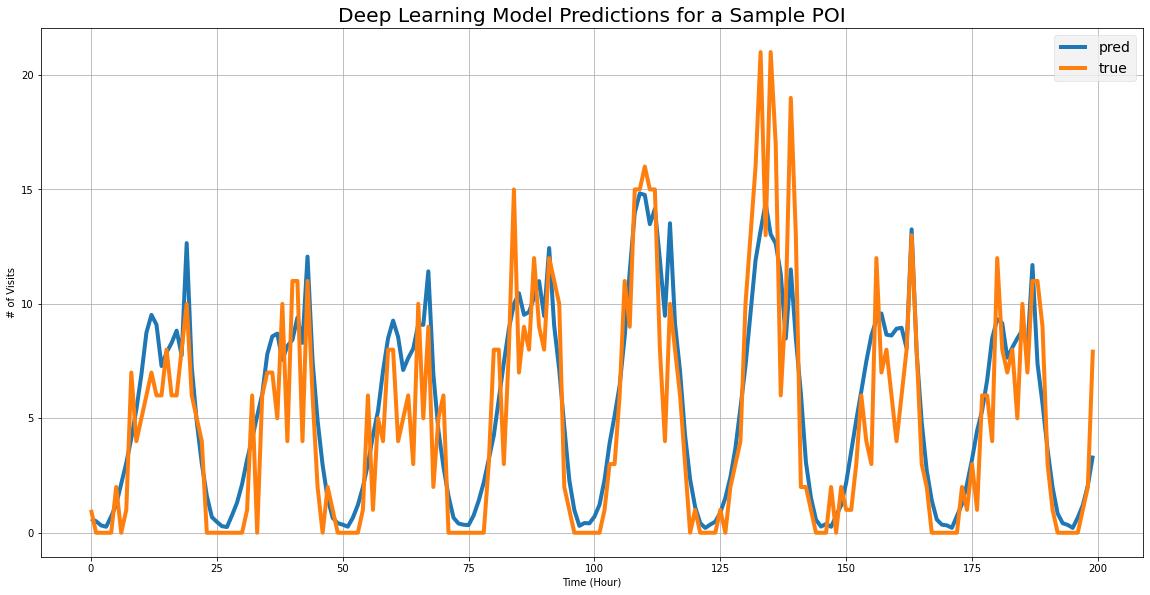

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(preds_data[:200, 200], label='pred')
plt.plot(target_data[:200, 200], label='true')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Deep Learning Model Predictions for a Sample POI')
plt.savefig(f"img/DeepLearning_Good_Result.png", bbox_inches = 'tight')

Text(0.5, 1.0, 'Deep Learning Model Predictions for a Sample POI')

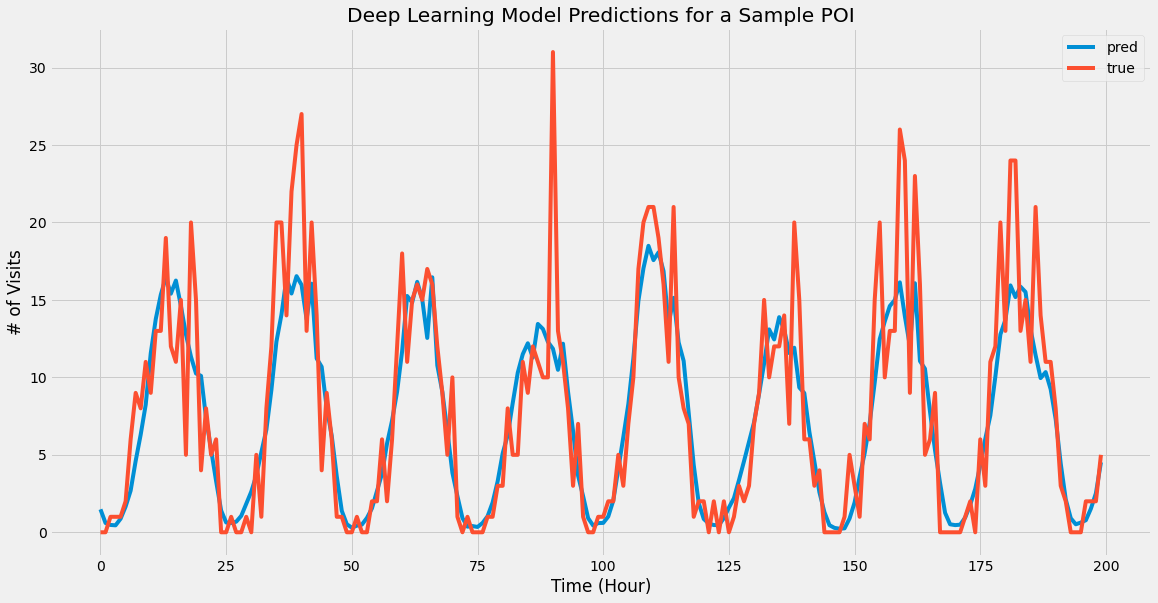

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.style.use('fivethirtyeight')
plt.plot(test_preds_data[:200, 200], label='pred')
plt.plot(test_target_data[:200, 200], label='true')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Deep Learning Model Predictions for a Sample POI')

In [15]:
preds_data[:200, :].mean(axis=0)

array([300.53440243, 118.8494866 , 104.04880029, 110.64159893,
       103.78305714,  72.30670418,  78.30867986,  50.04039079,
        46.00617506,  49.04615952,  40.36308151,  34.72542887,
        33.23636727,  28.63086306,   3.70464067,  60.65177924,
        27.7819306 ,  36.68079124,  21.97720683,  24.12627884,
        25.58679021,  20.68770598,  24.88472592,  21.09563709,
        18.60326246,  23.00067281,  37.11247367,  18.37166476,
        16.86541222,  22.22578397,  20.32289248,  16.04469835,
        24.43882936,  18.00313705,  17.19362022,  22.43535144,
        18.49441781,  14.77226146,  16.98565454,  14.18633298,
        17.37485755,  14.96562539,  15.78863812,   8.03929472,
        13.96077638,  13.60512823,  14.21608919,  12.25853497,
        16.07299102,  12.76754328,  15.40702368,  12.42790473,
        24.43918407,  12.31894218,  13.09273282,  12.50950242,
        19.6017923 ,  22.3061101 ,  12.79370061,  11.05401412,
        21.14955722,  19.92522572,  11.06176045,  11.54

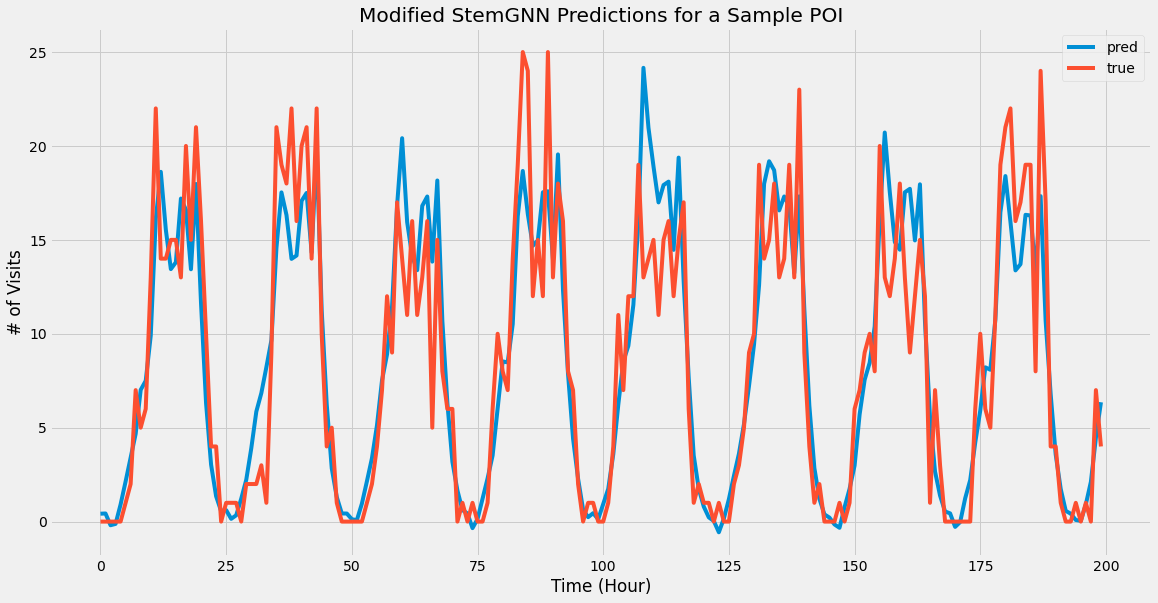

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(preds_data[:200, 100], label='pred')
plt.plot(target_data[:200, 100], label='true')
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Modified StemGNN Predictions for a Sample POI')
plt.savefig(f"img/DeepLearning_Good_Result.png", bbox_inches = 'tight')

In [17]:
np.where(target_data[:200, 33] < 0, 0, target_data[:200, 33])

array([ 1.00000053,  0.        ,  0.        ,  0.        ,  3.00000026,
        3.00000026,  4.99999999, 22.00000005, 16.99999994, 21.00000005,
       22.00000005, 34.00000026, 31.99999948, 42.00000023, 27.00000016,
       24.00000004, 45.00000087, 25.99999977, 28.99999989, 34.00000026,
       13.99999982,  7.99999958,  1.00000053,  3.00000026,  1.99999934,
        1.00000053,  0.        ,  0.        ,  1.00000053,  3.00000026,
        5.99999985, 12.99999995, 29.99999975, 21.00000005, 22.99999991,
       38.00000077, 45.99999969, 43.99999996, 25.99999977, 30.99999962,
       25.99999977, 22.99999991, 22.00000005, 38.00000077, 16.00000007,
        7.99999958,  1.00000053,  1.99999934,  0.        ,  1.00000053,
        0.        ,  1.00000053,  1.00000053,  4.99999999,  6.99999971,
        5.99999985, 16.99999994, 16.00000007, 18.00000006, 45.00000087,
       45.00000087, 33.0000004 , 28.00000002, 40.0000005 , 38.99999959,
       29.99999975, 22.00000005, 24.00000004, 16.00000007,  5.99

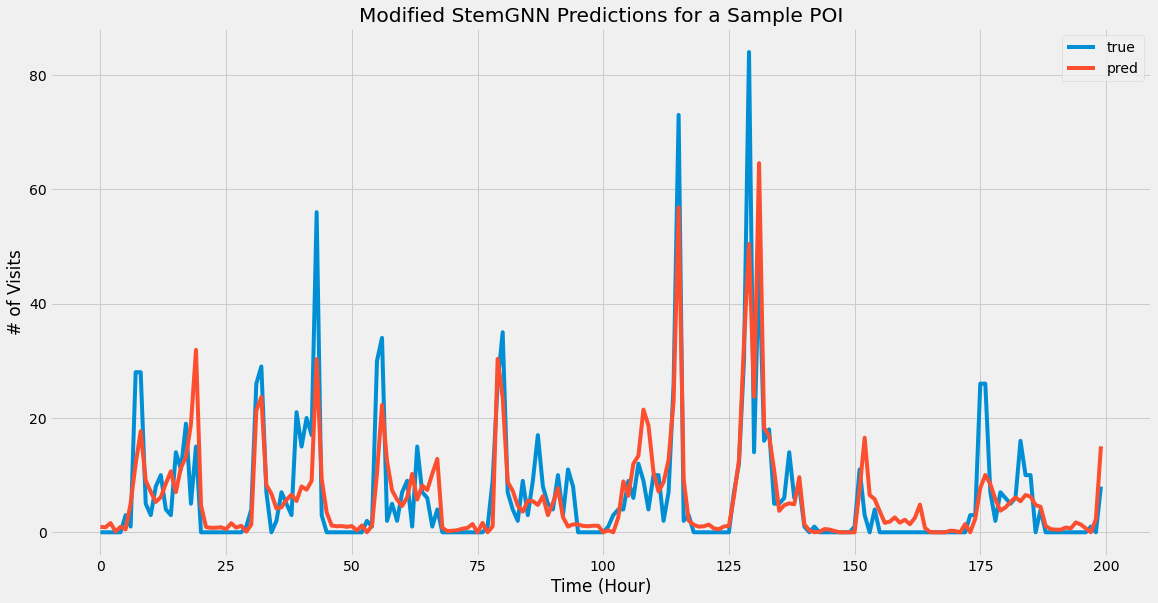

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
poi_num = 260
# plt.plot(preds_data[:200, poi_num], label='pred')
plt.plot(target_data[:200, poi_num], label='true')
aaa = np.where(preds_data[:200, poi_num] < 0, 0, preds_data[:200, poi_num])
plt.plot(aaa, label='pred')
plt.legend()
plt.style.use('fivethirtyeight')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Time (Hour)')
plt.ylabel('# of Visits')
plt.title('Modified StemGNN Predictions for a Sample POI')
plt.savefig(f"img/DeepLearning_Bad_Result.png", bbox_inches = 'tight')

/tmp/ipykernel_22471/1280783951.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 8))


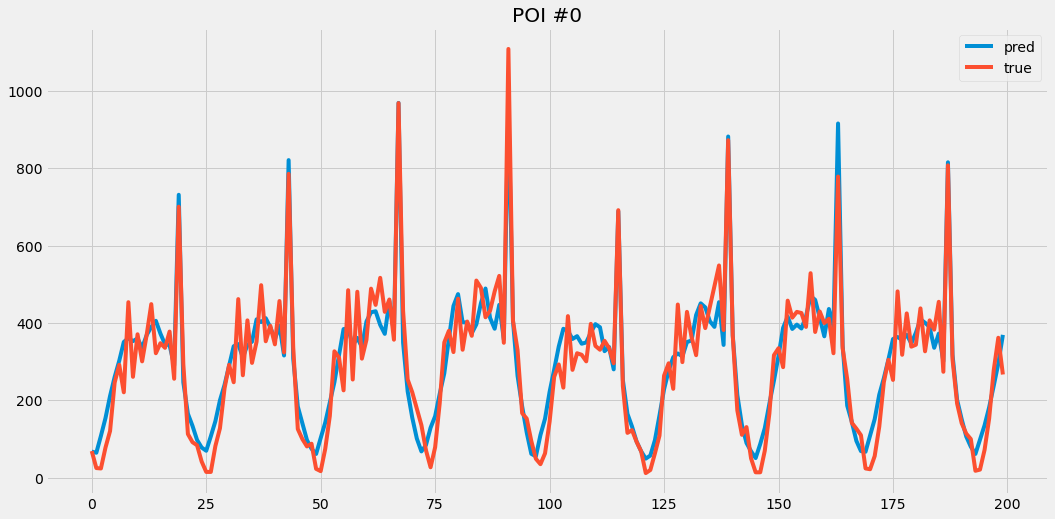

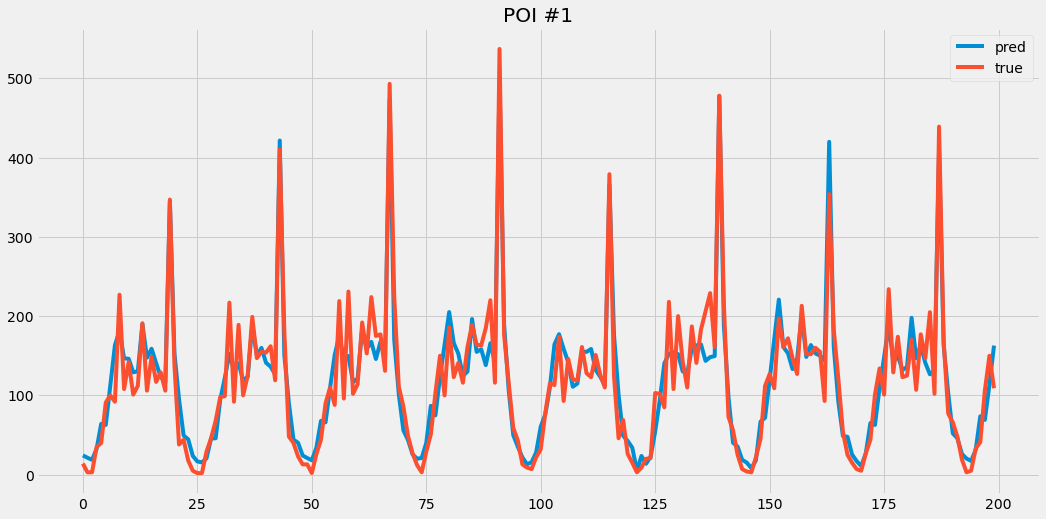

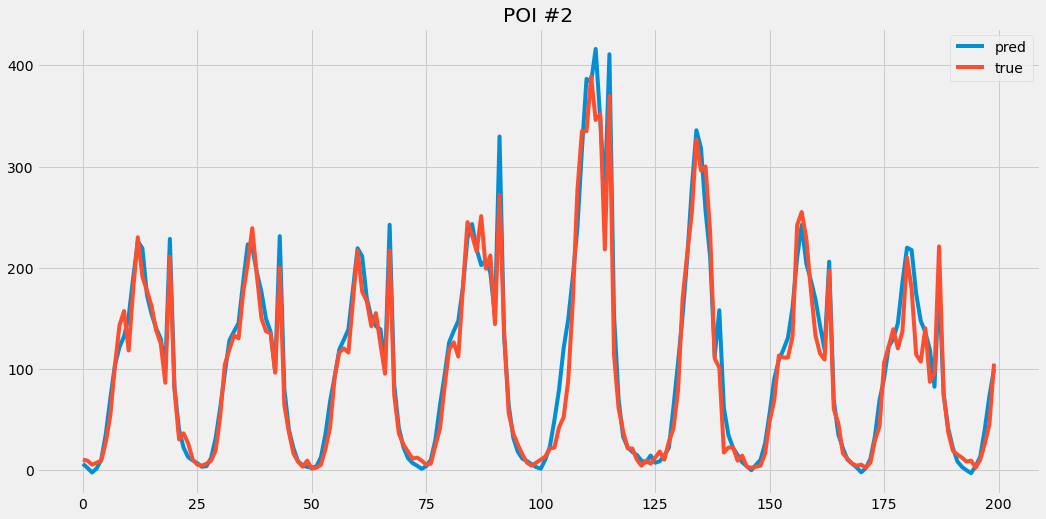

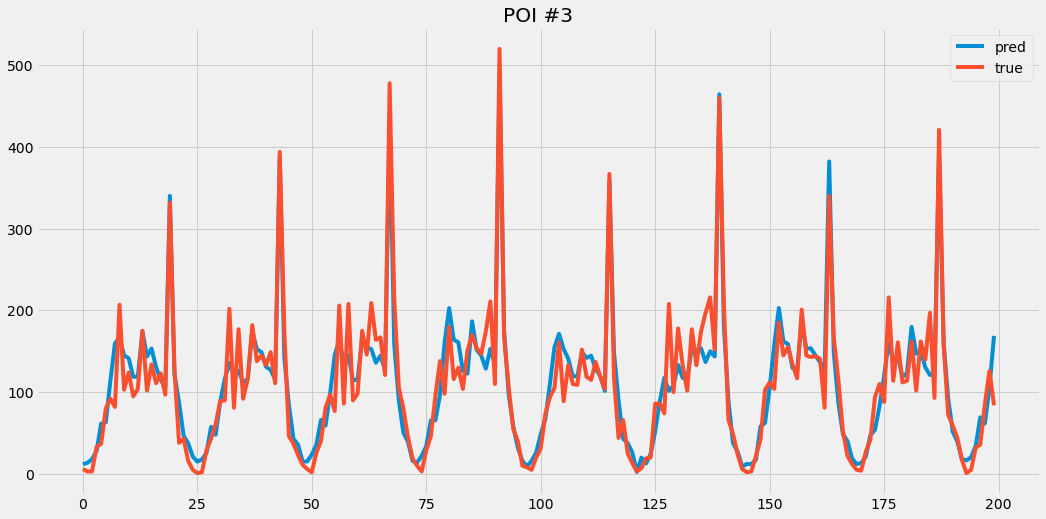

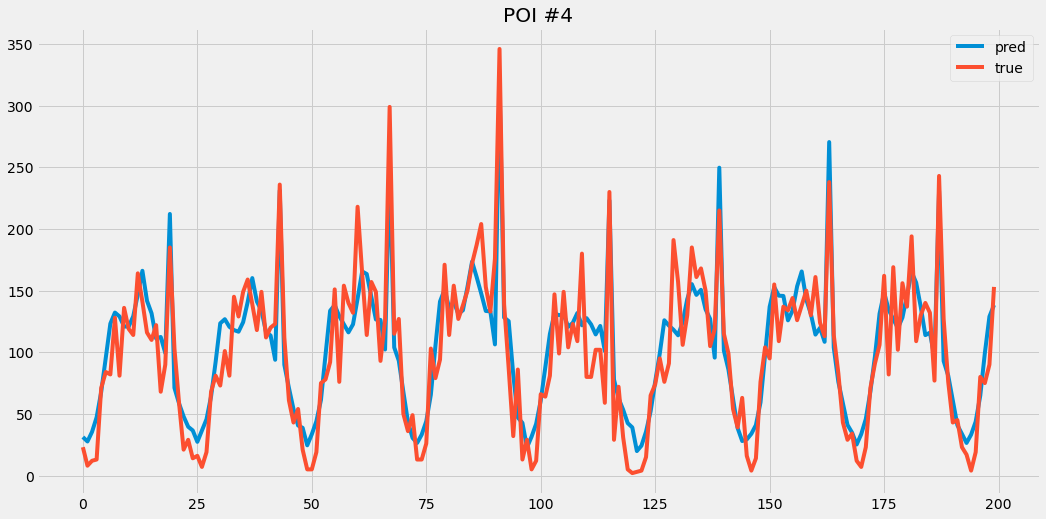

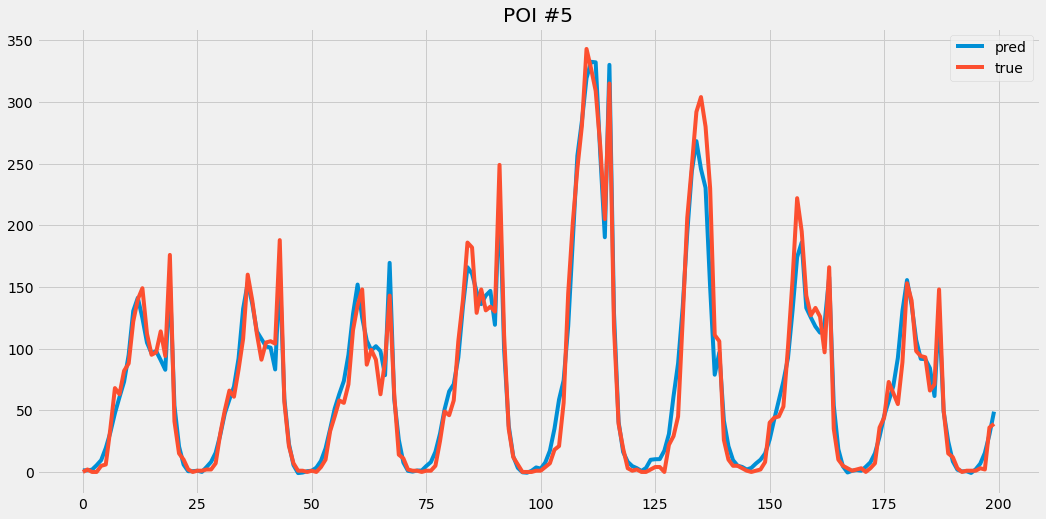

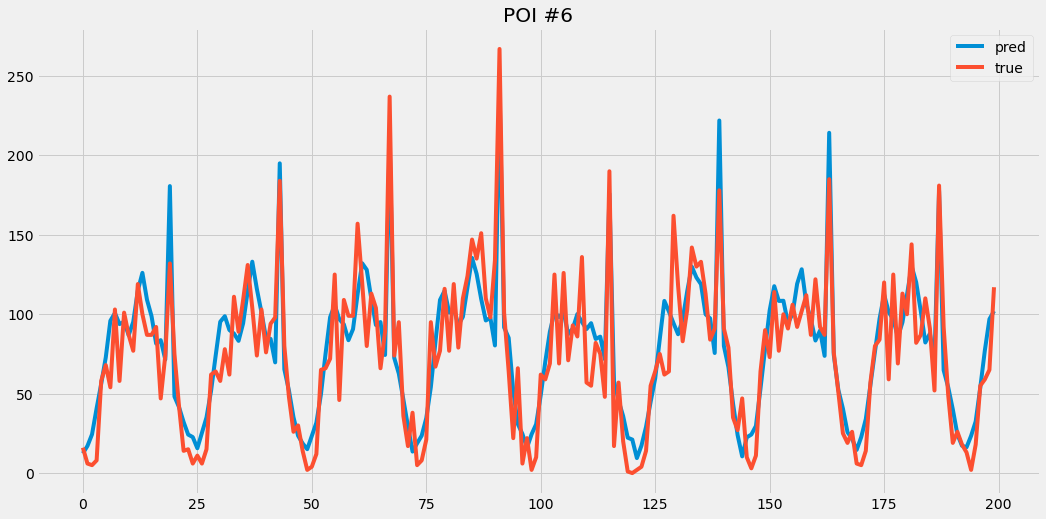

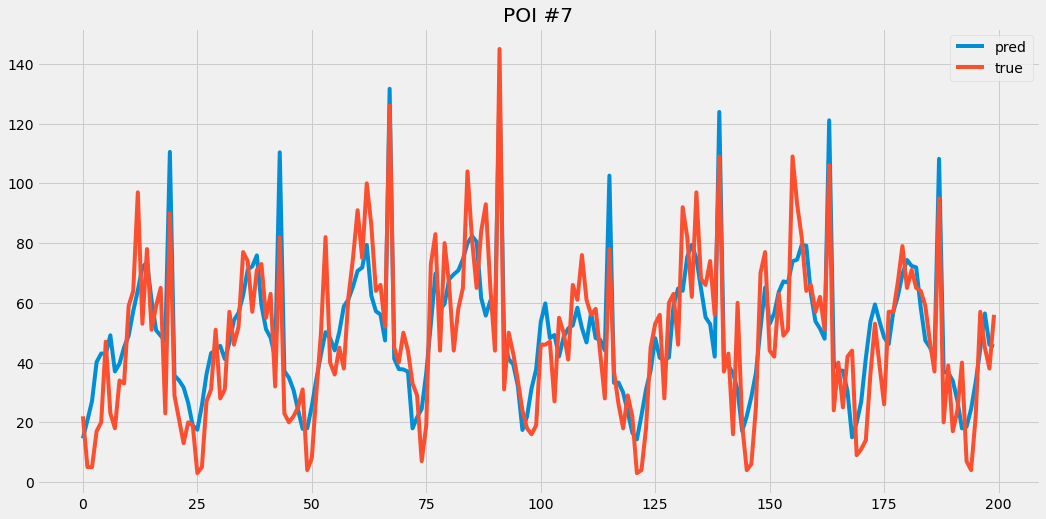

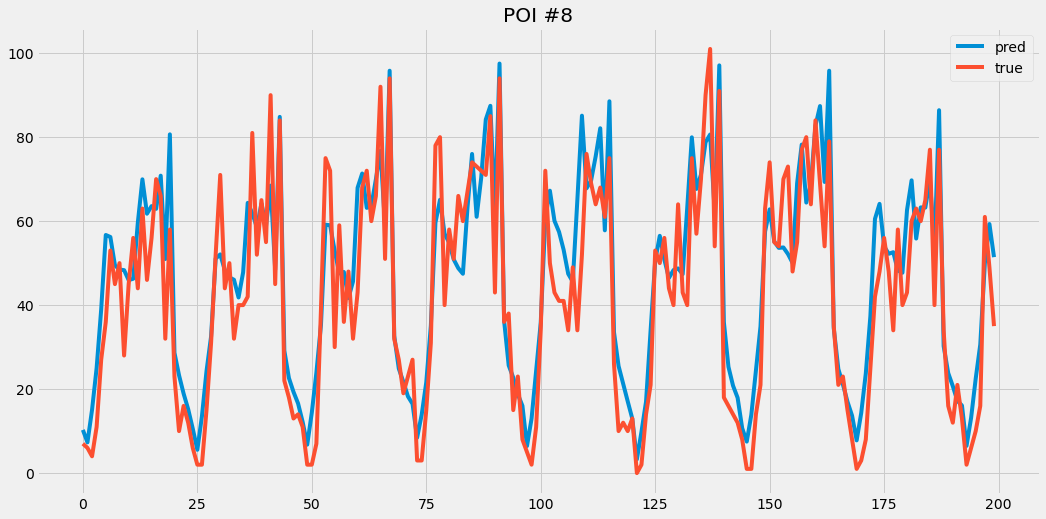

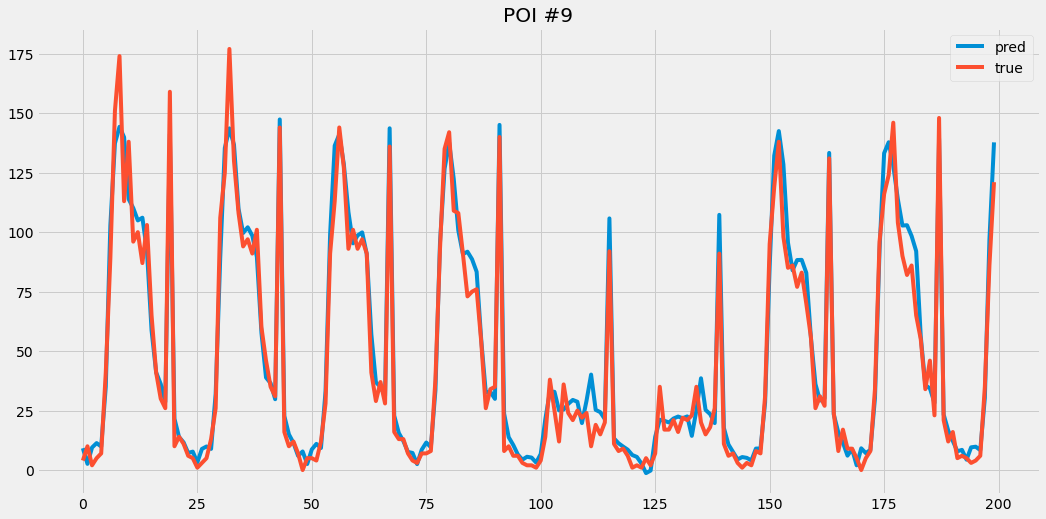

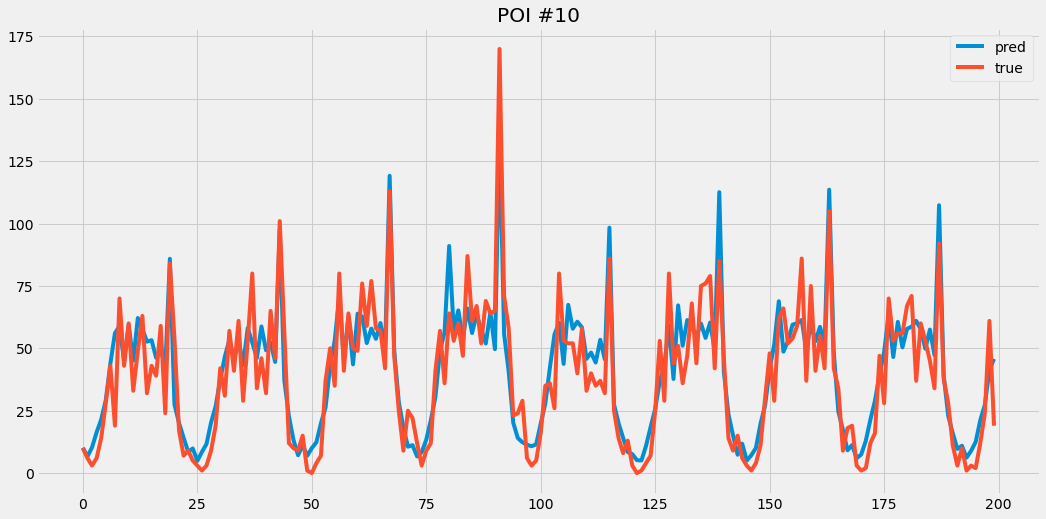

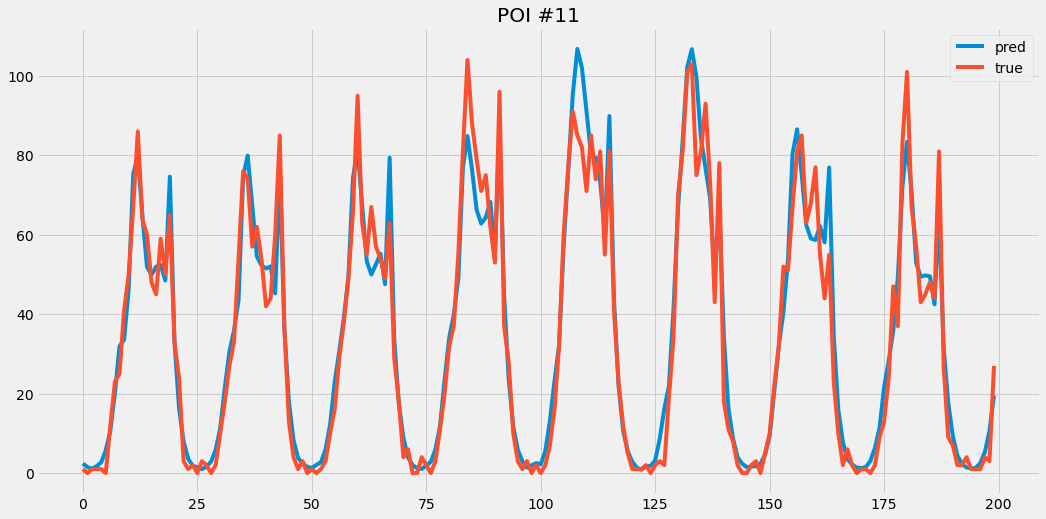

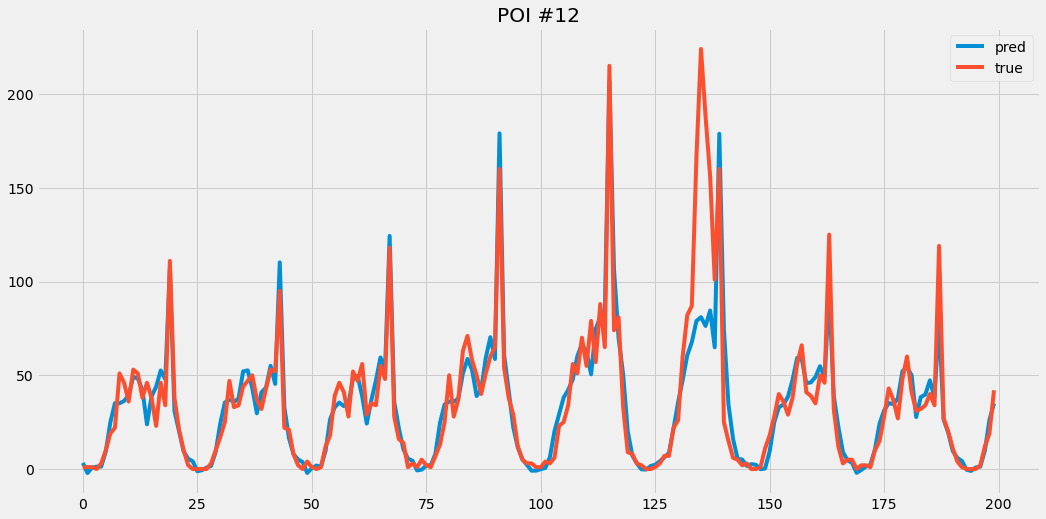

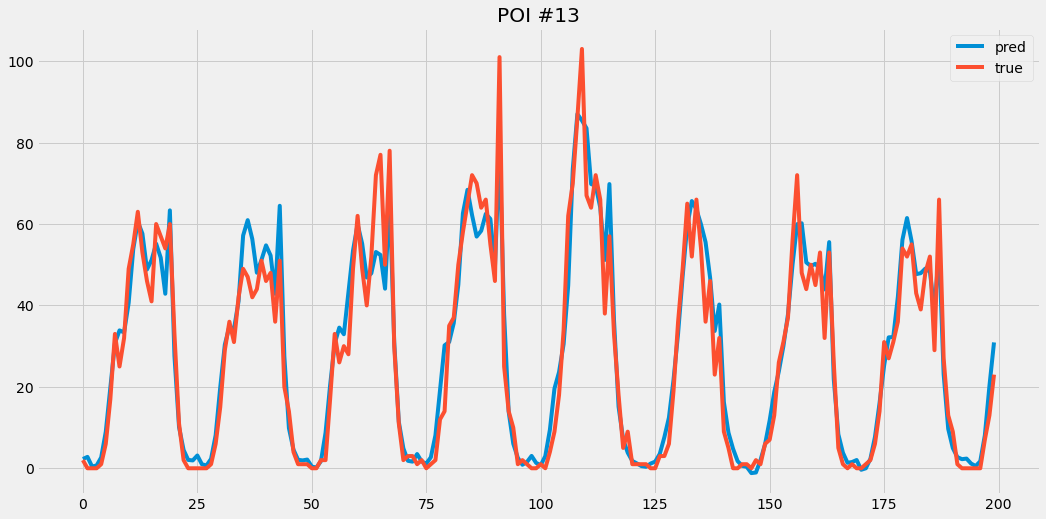

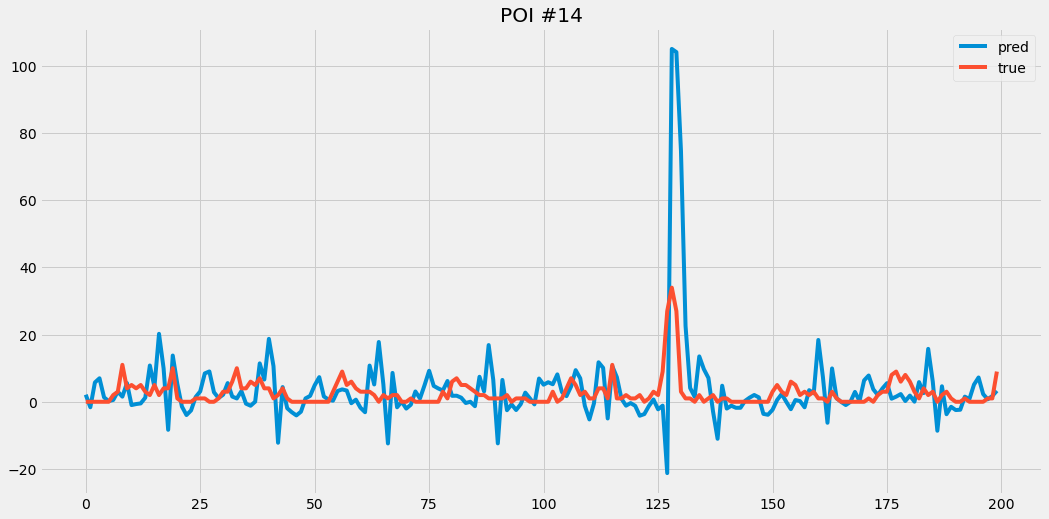

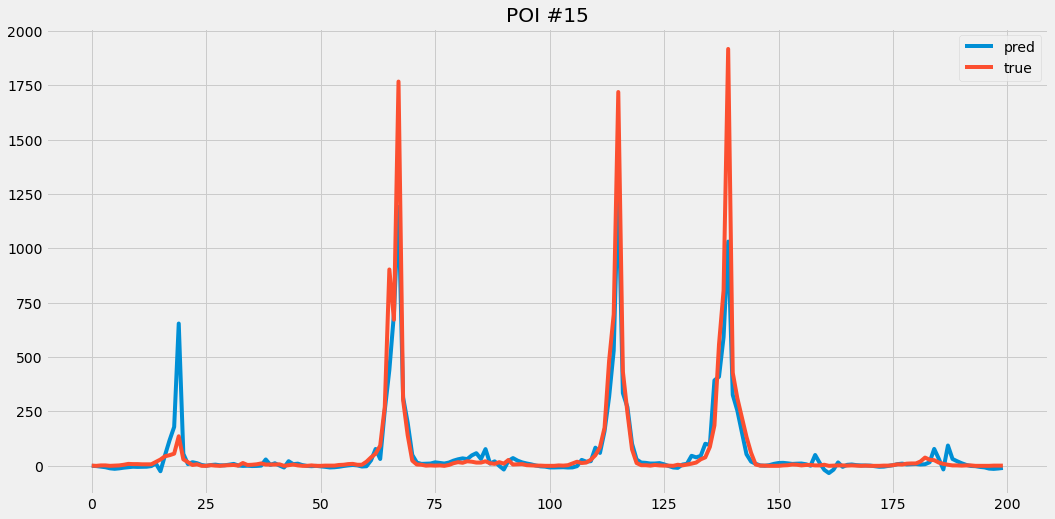

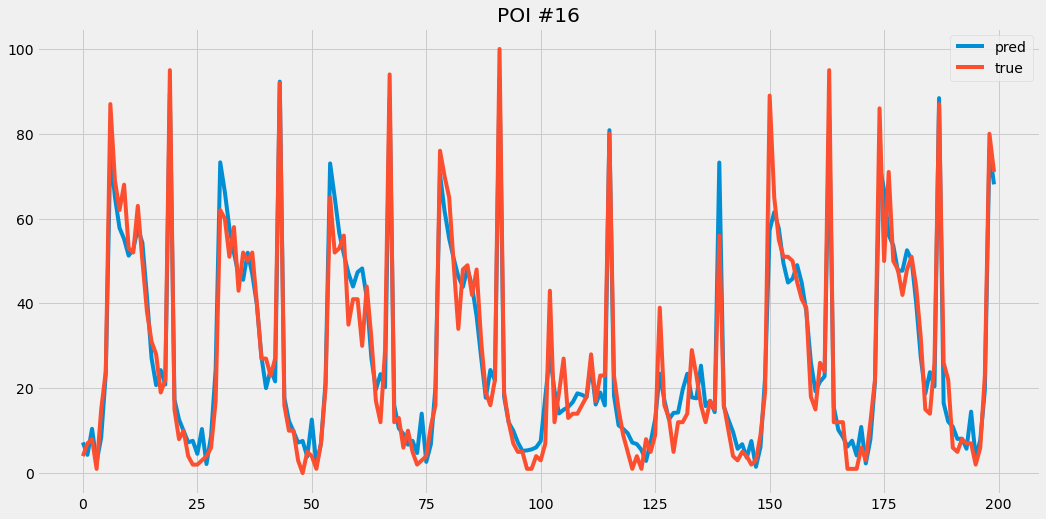

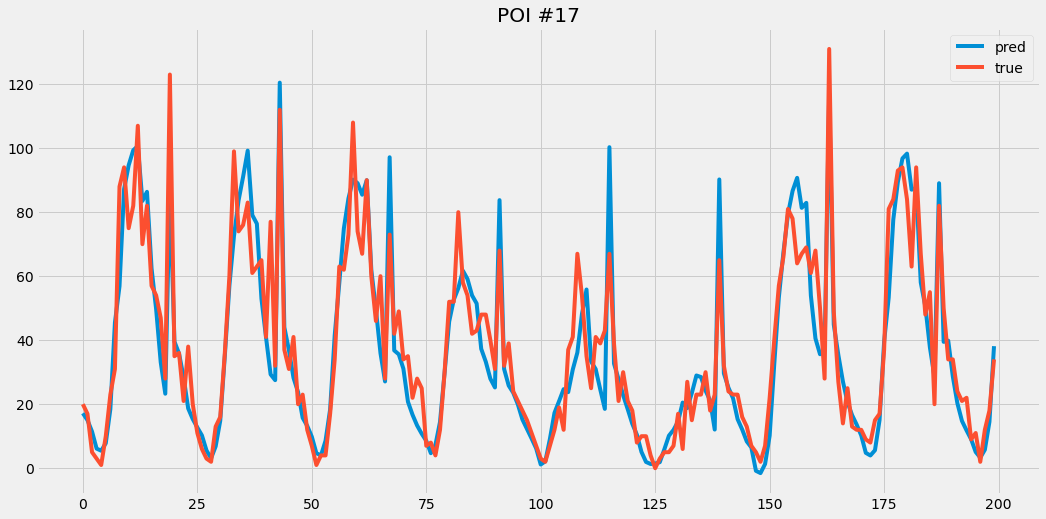

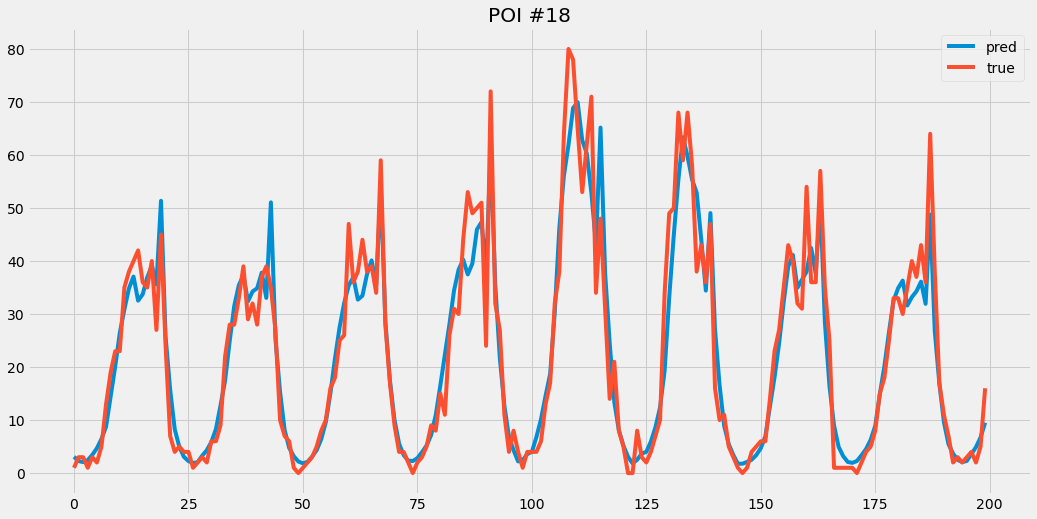

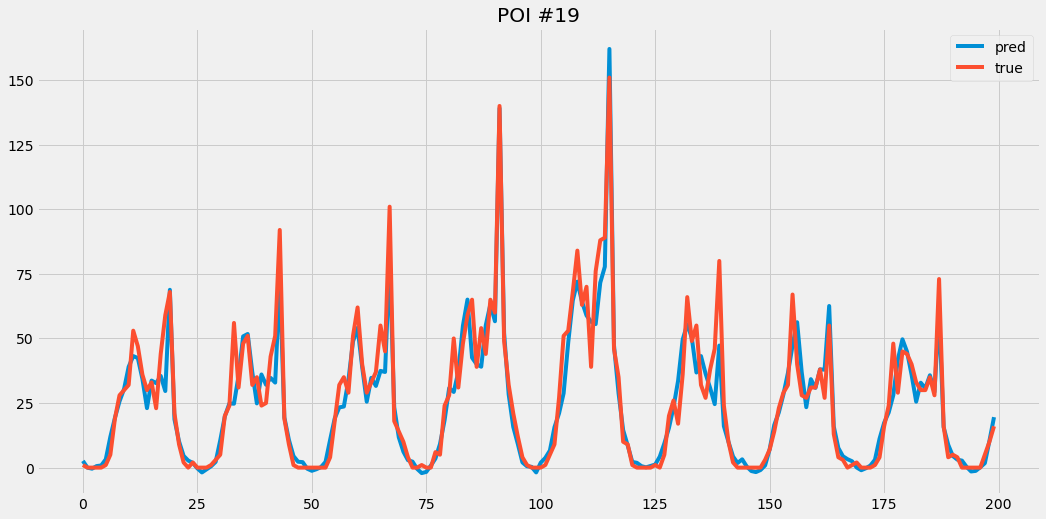

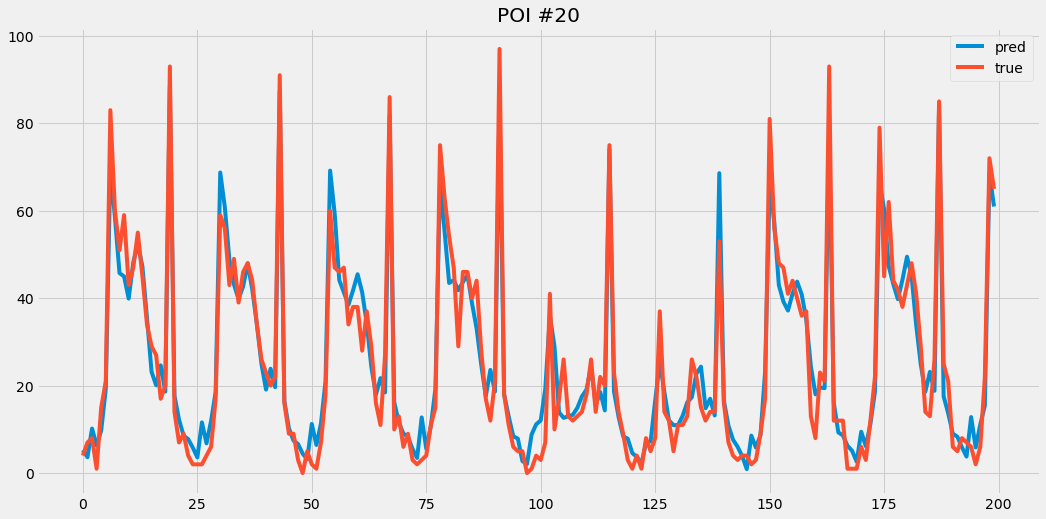

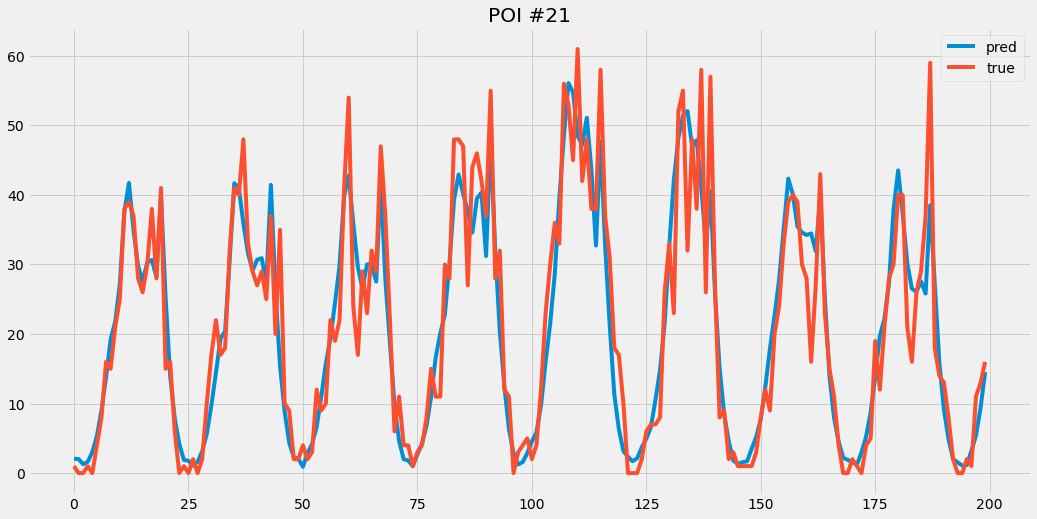

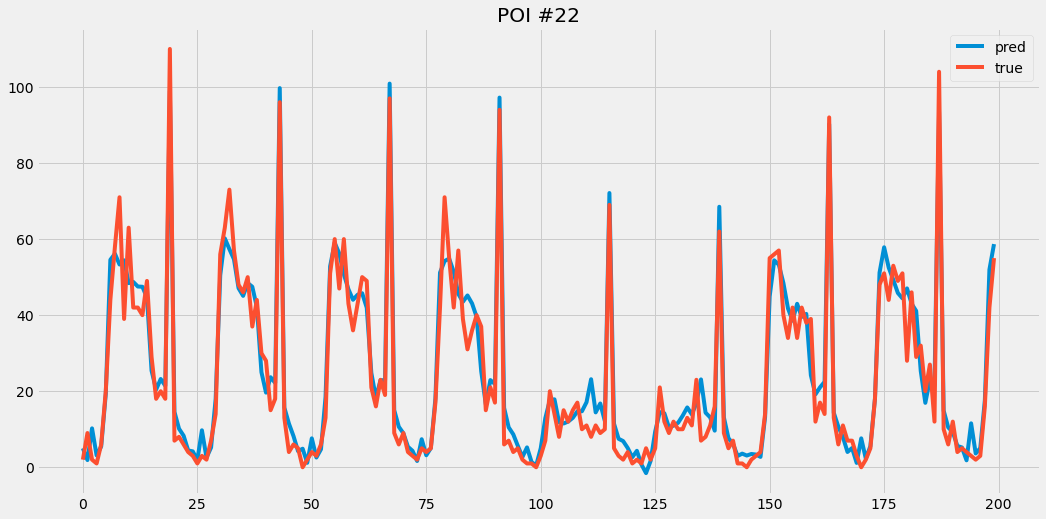

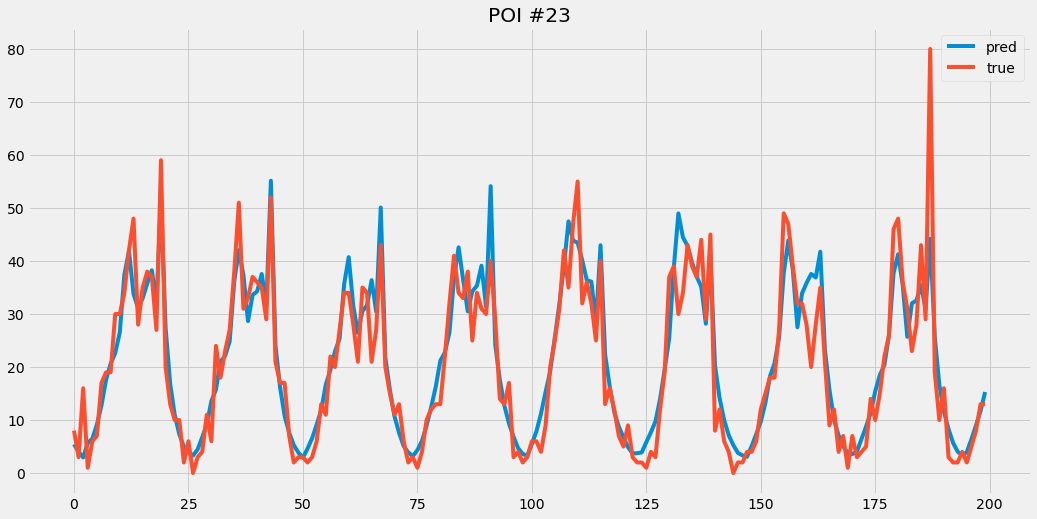

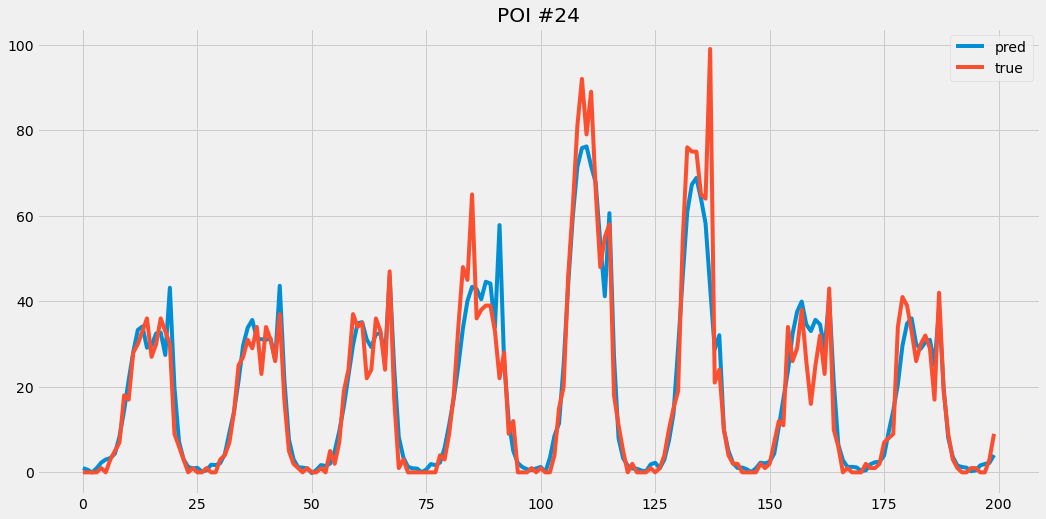

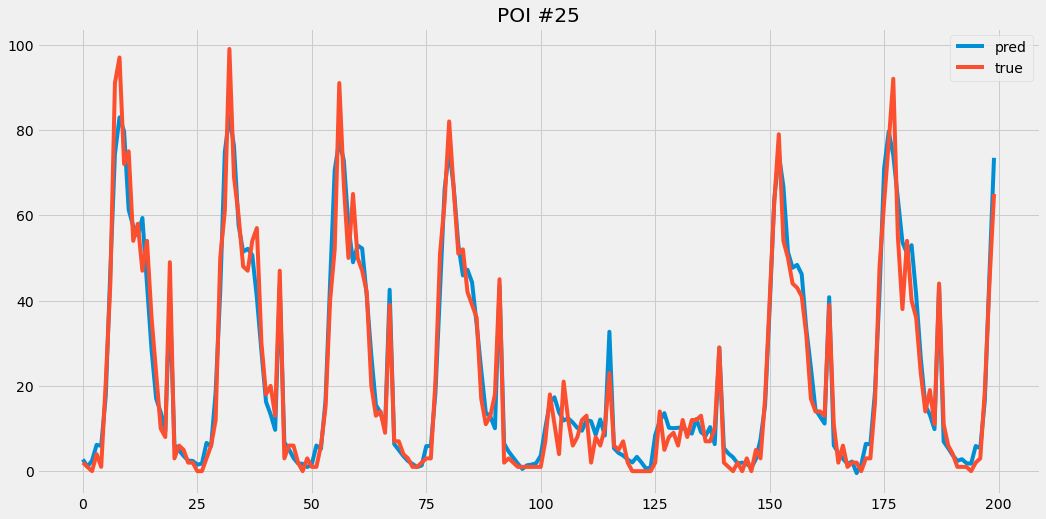

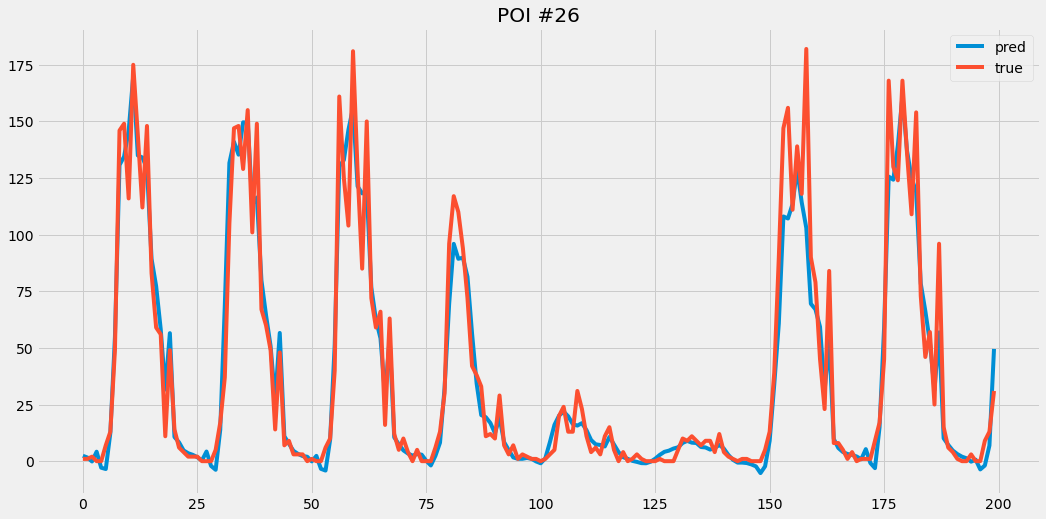

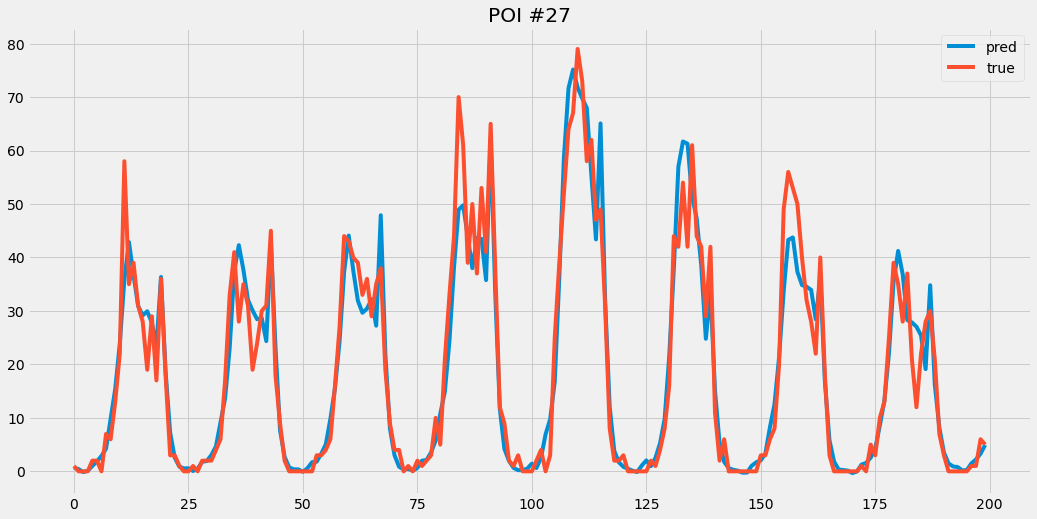

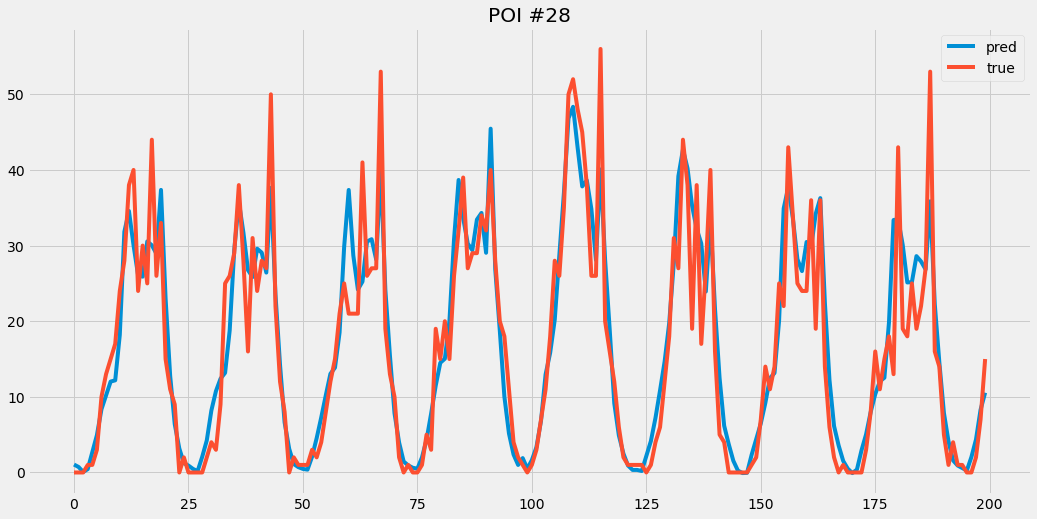

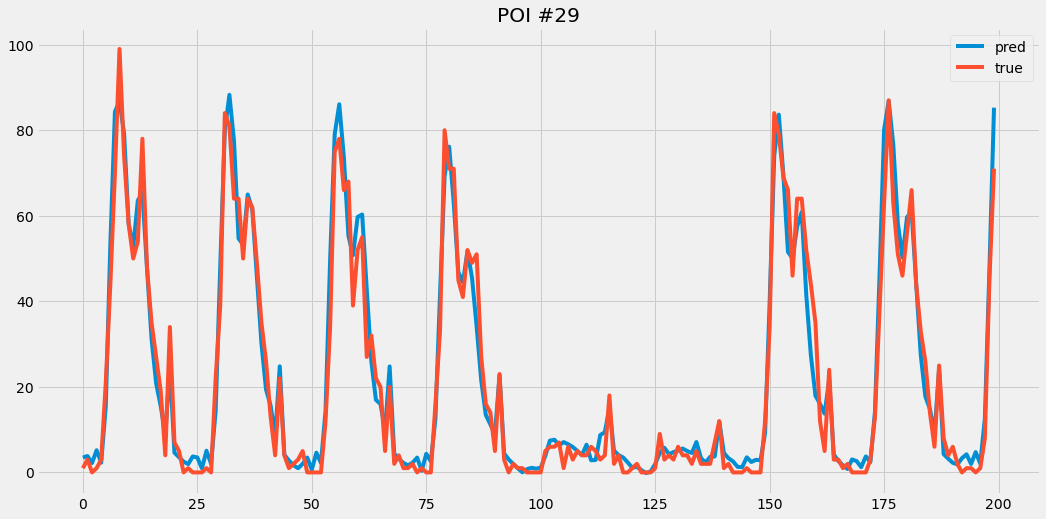

In [19]:
POI_NUM = 0
for i in range(30):
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(f'POI #{POI_NUM}')
    plt.plot(preds_data[:200, POI_NUM], label='pred')
    plt.plot(target_data[:200, POI_NUM], label='true')
    plt.legend()
    POI_NUM += 1
    # time.sleep(1)

/tmp/ipykernel_22471/2662101035.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(16, 8))


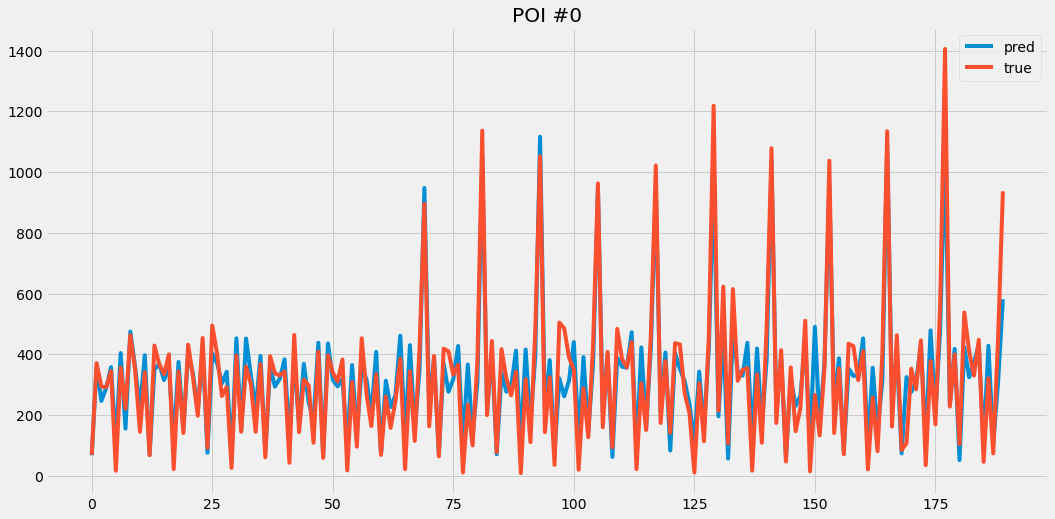

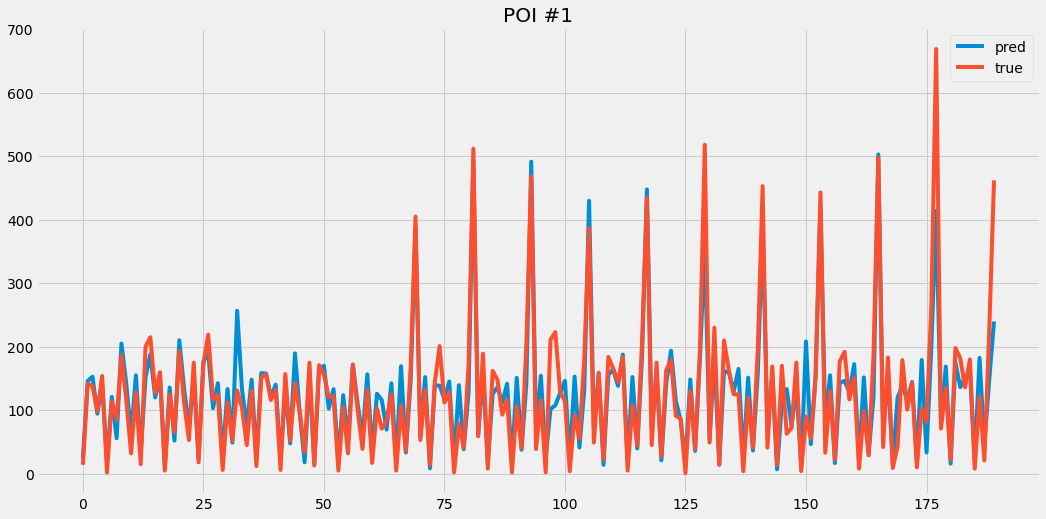

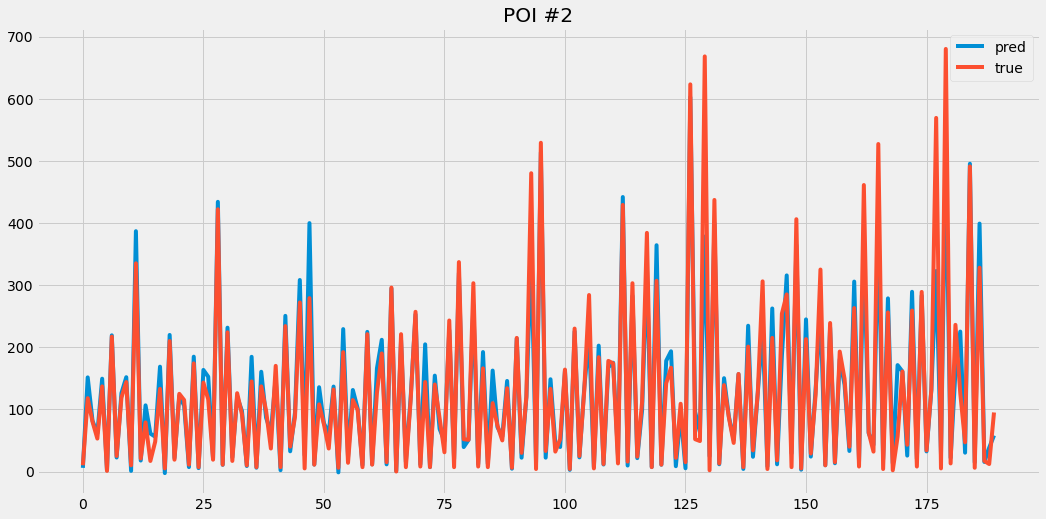

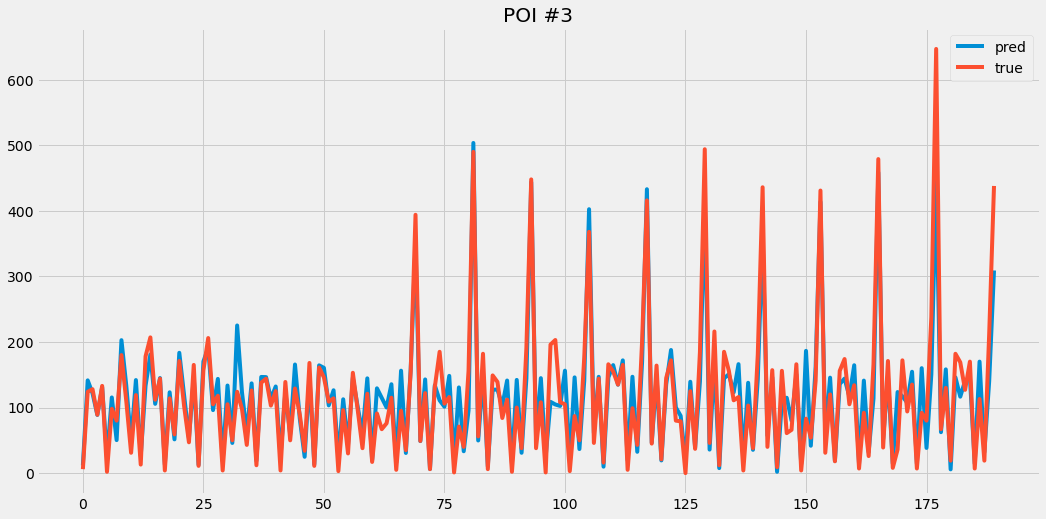

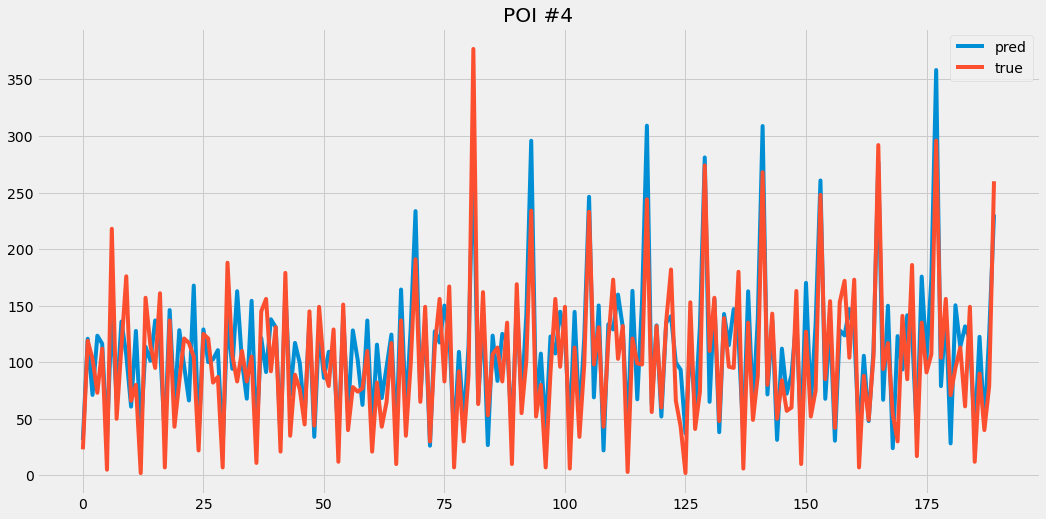

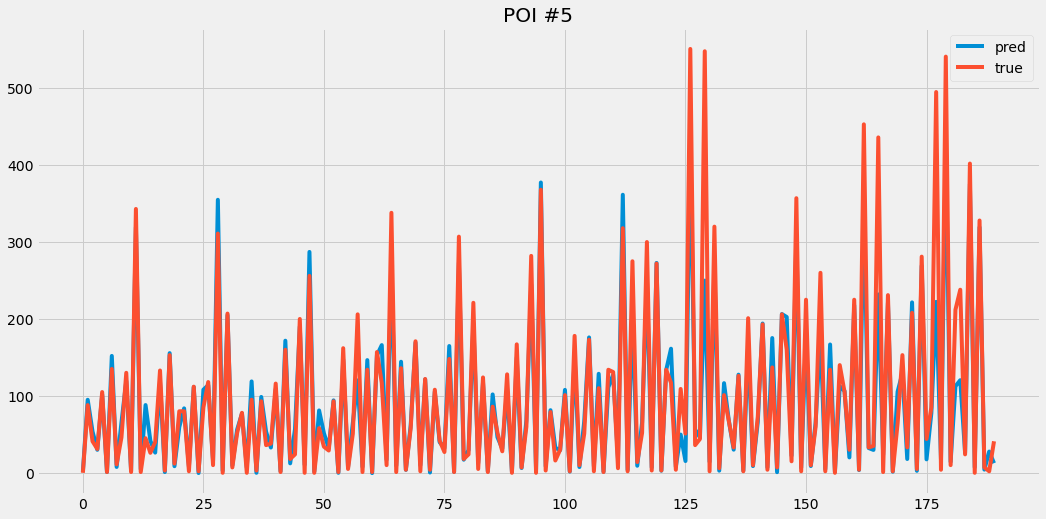

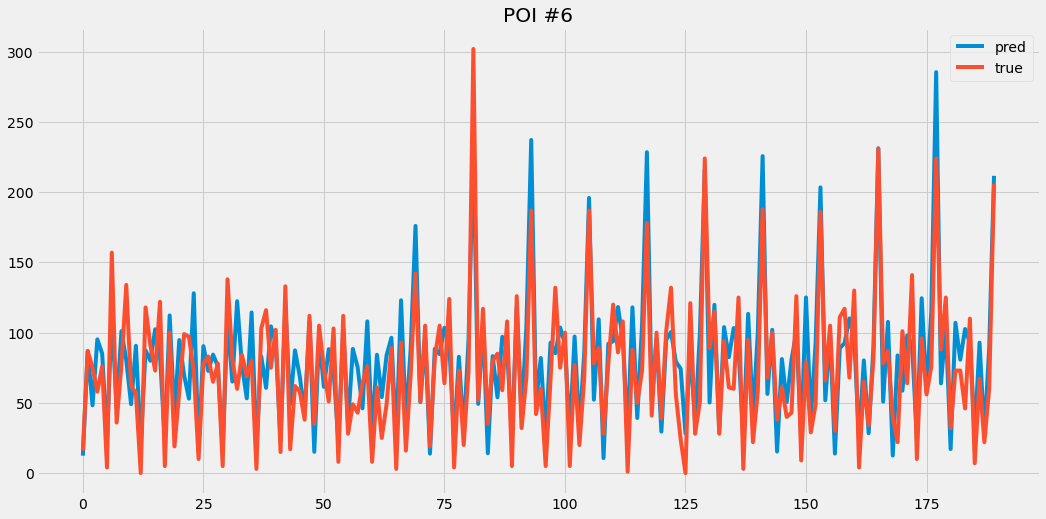

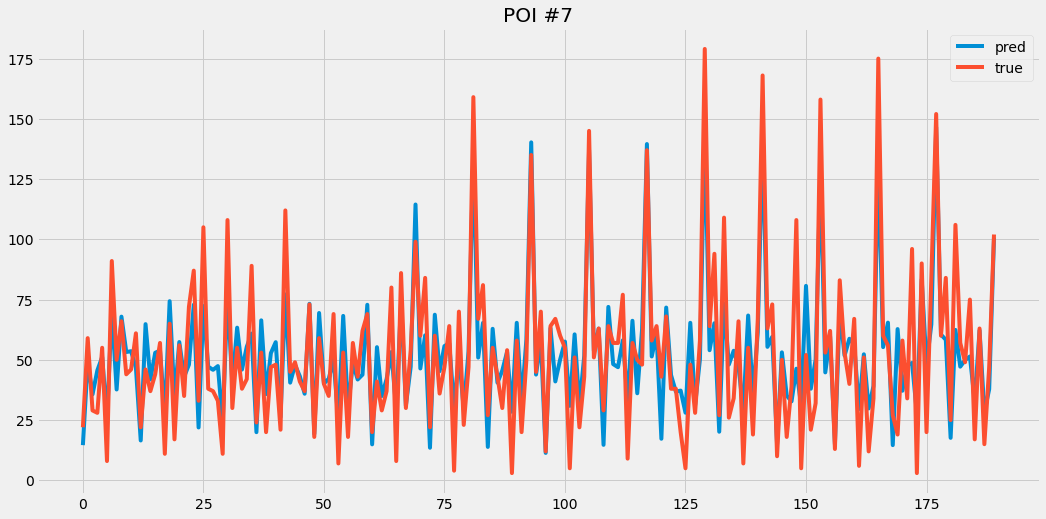

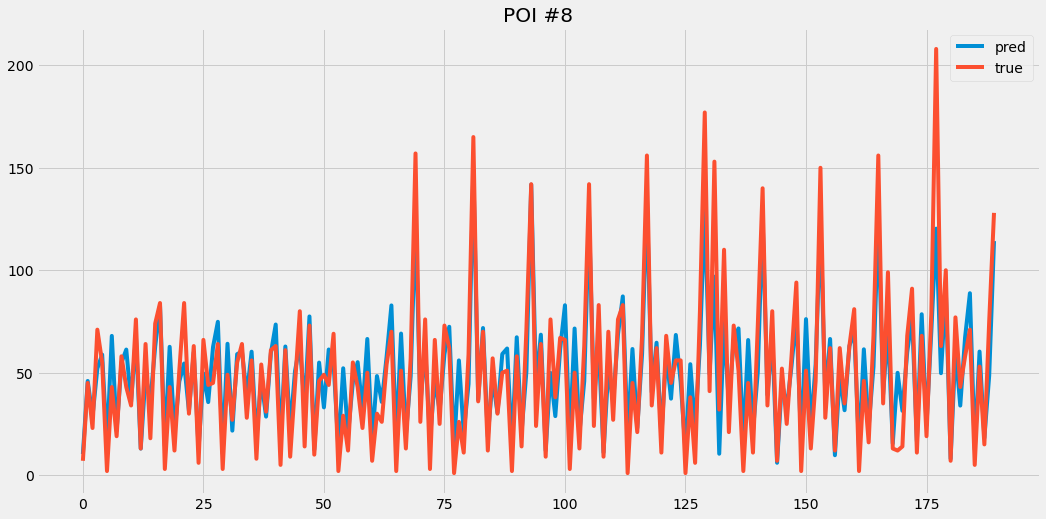

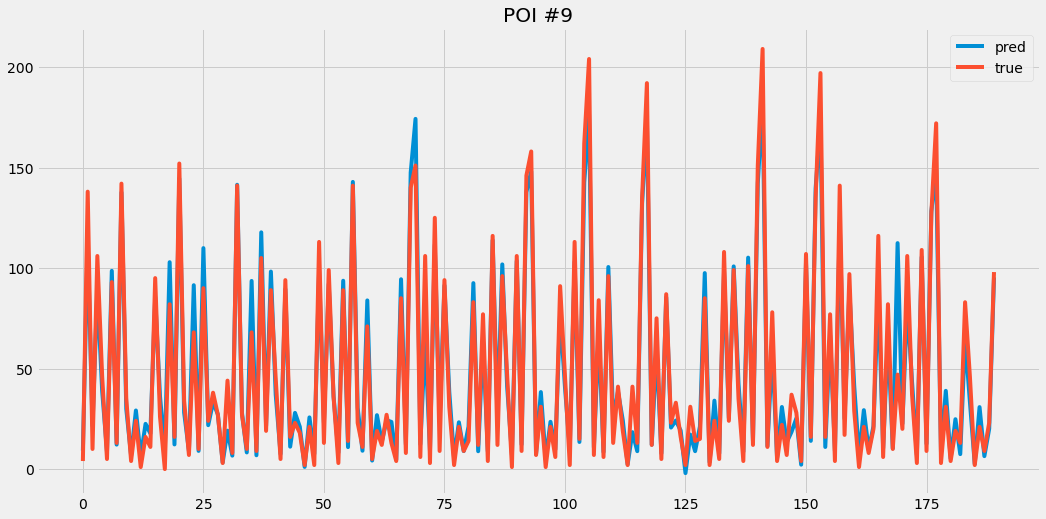

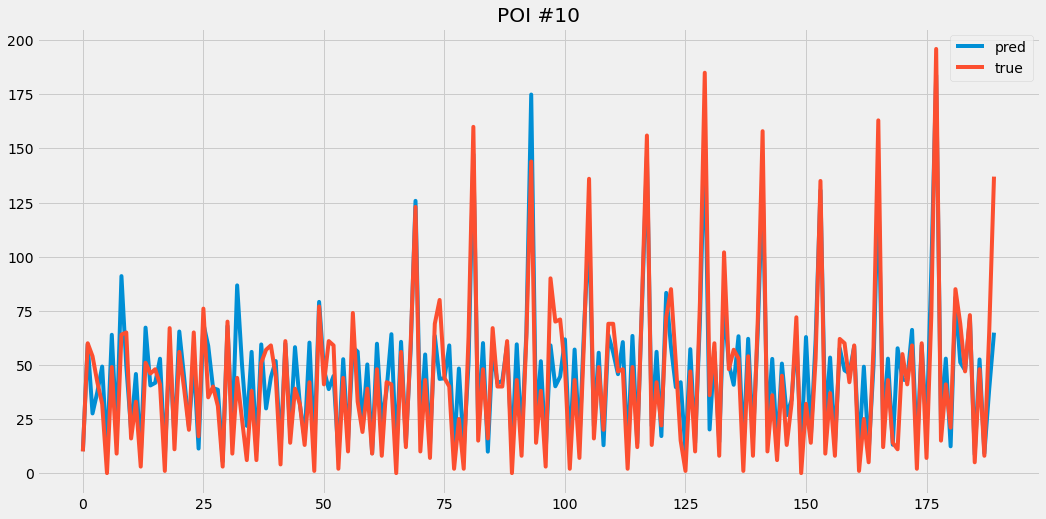

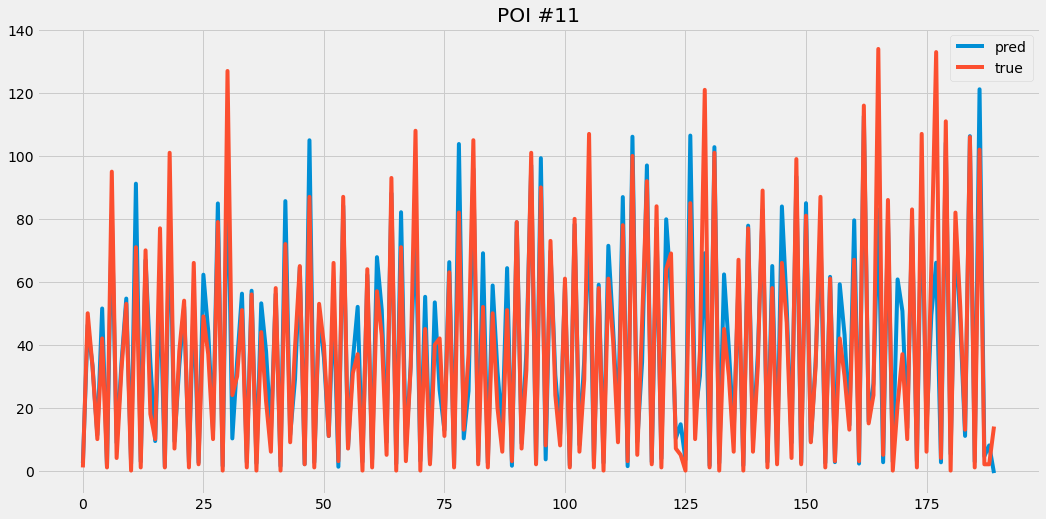

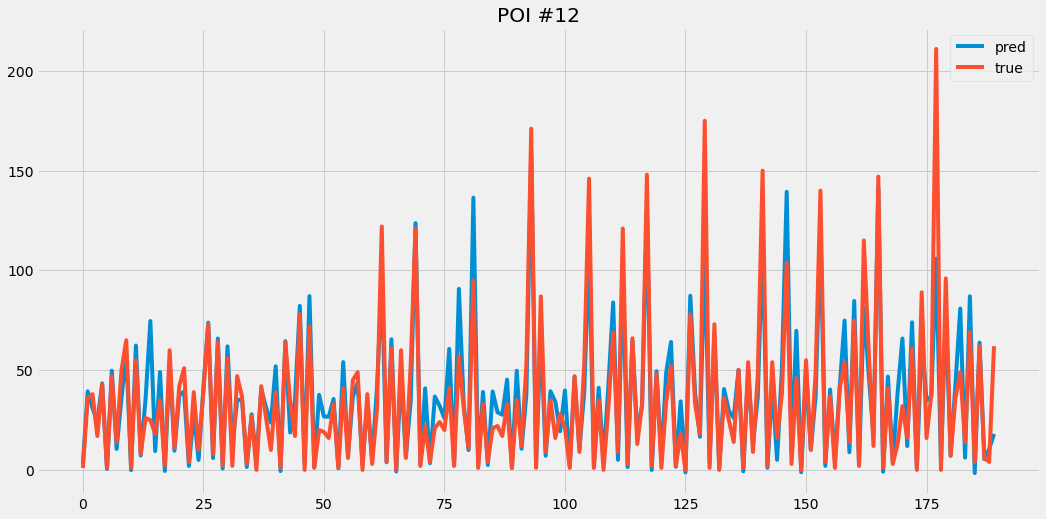

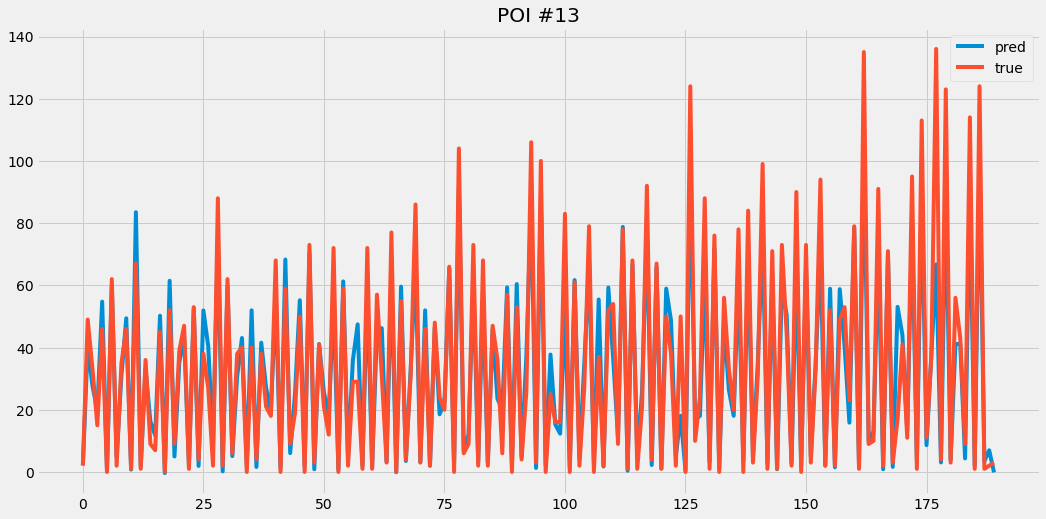

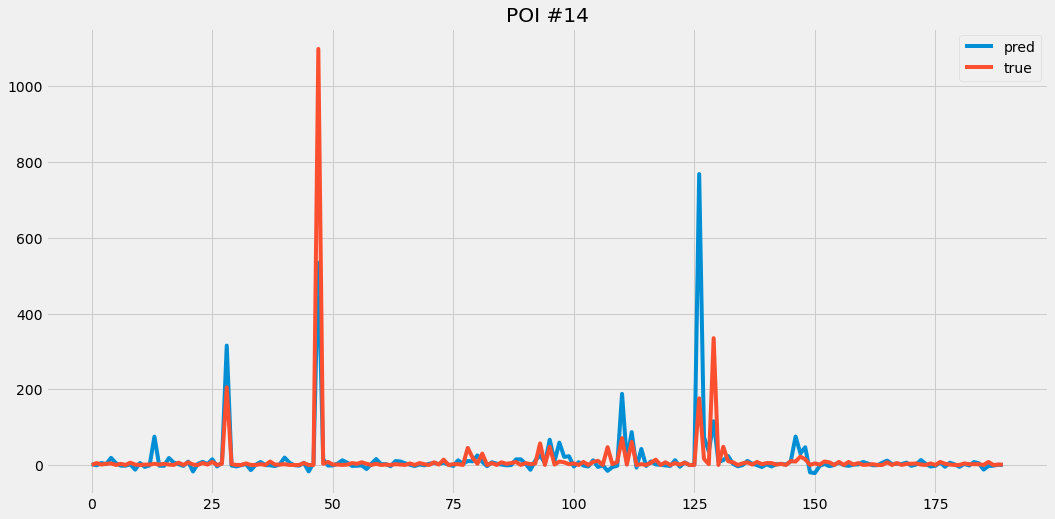

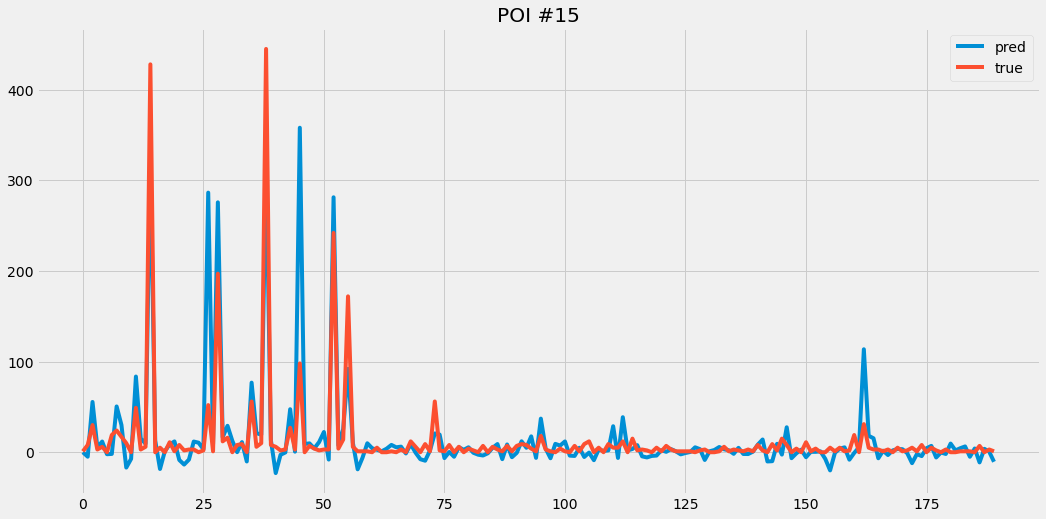

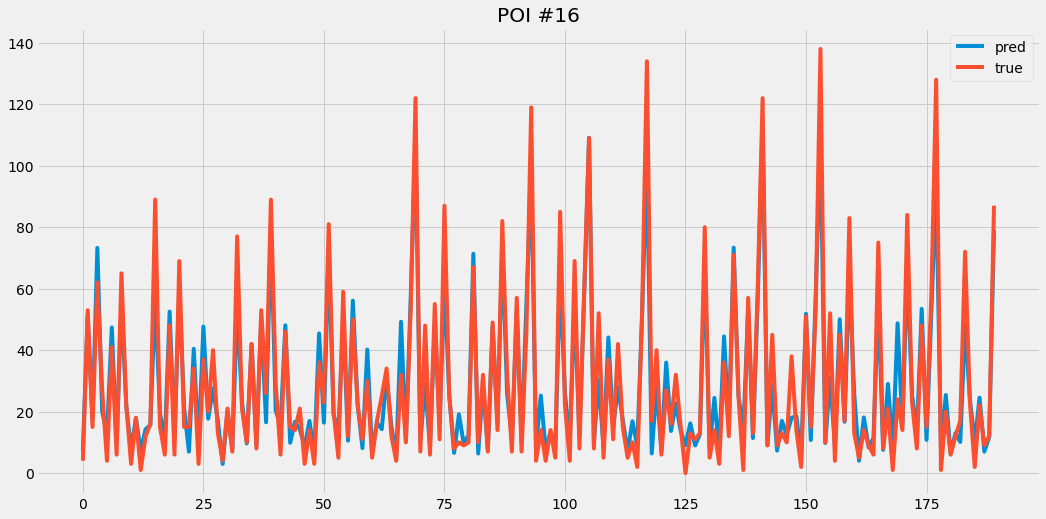

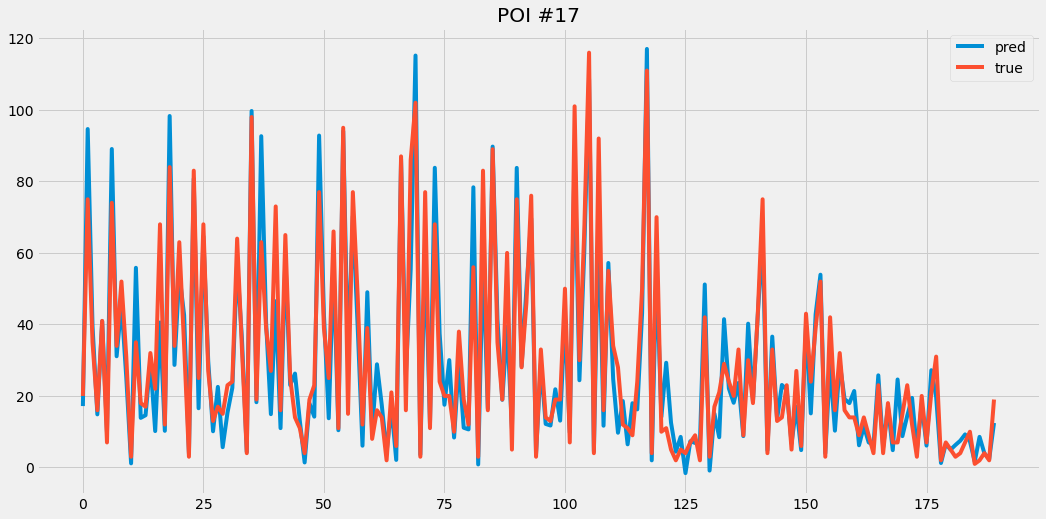

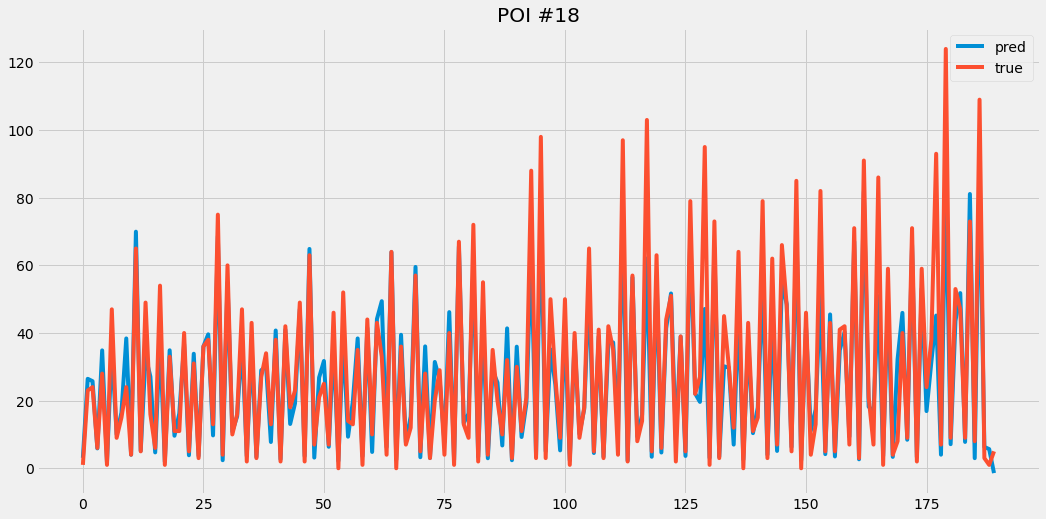

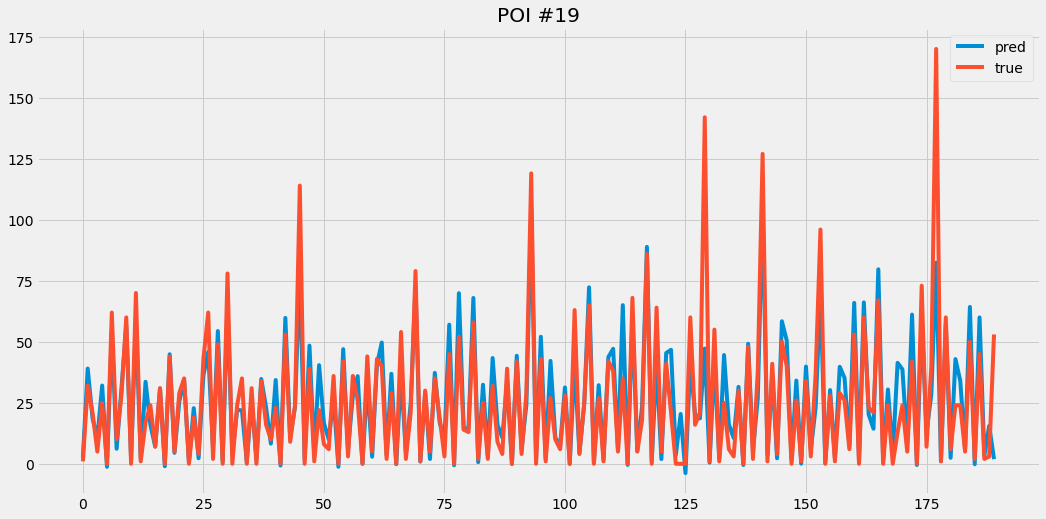

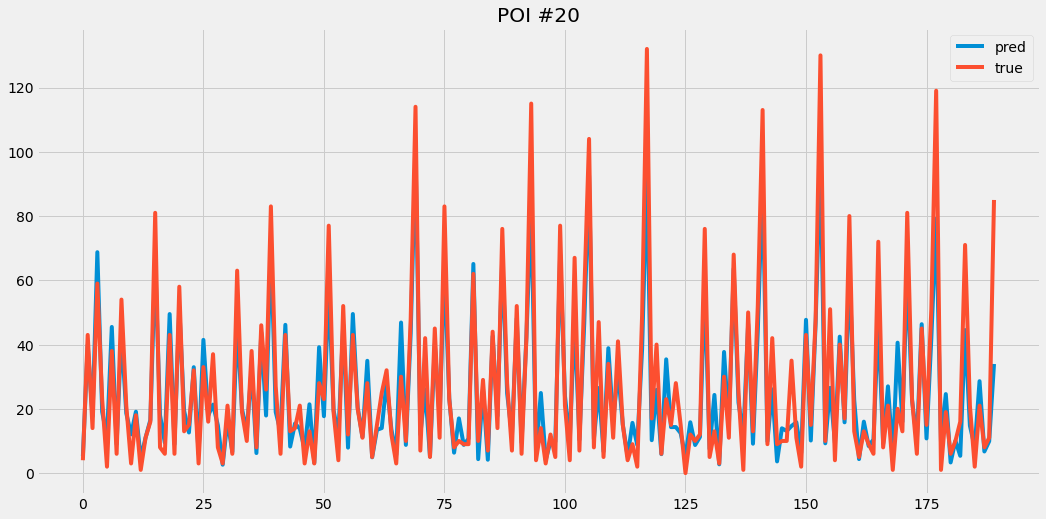

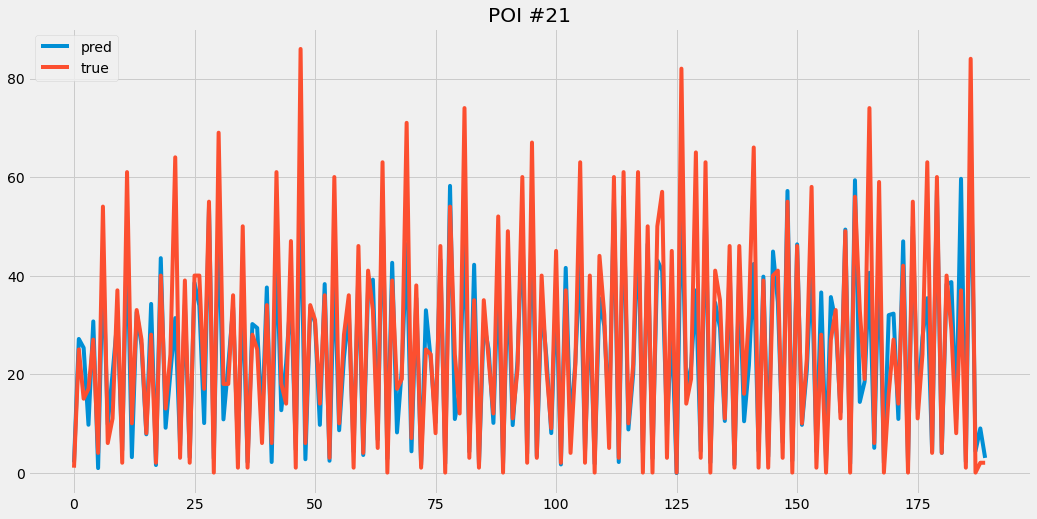

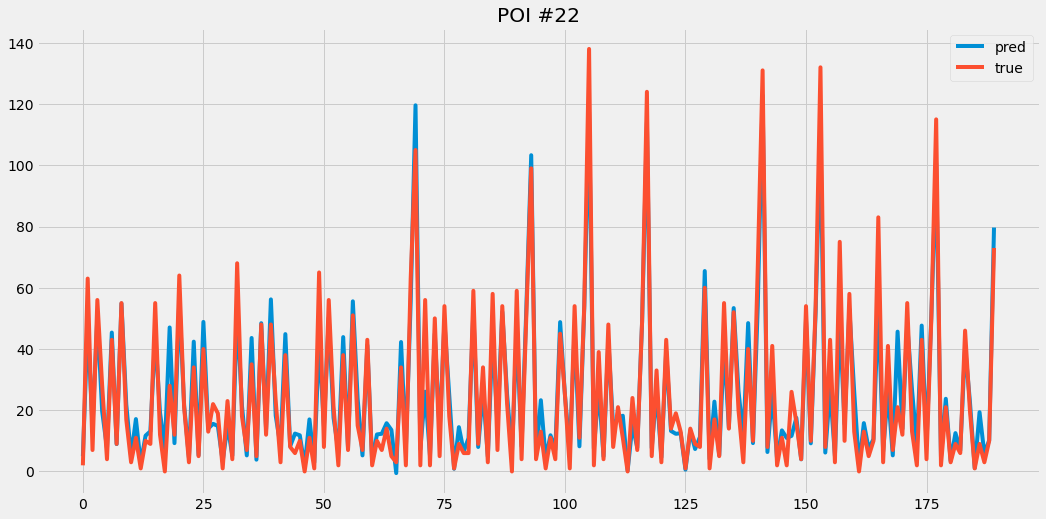

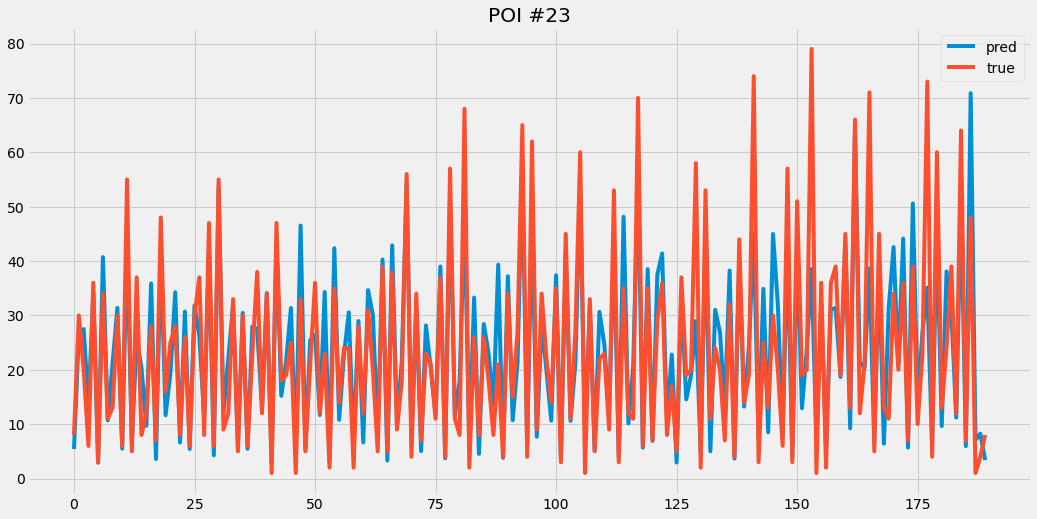

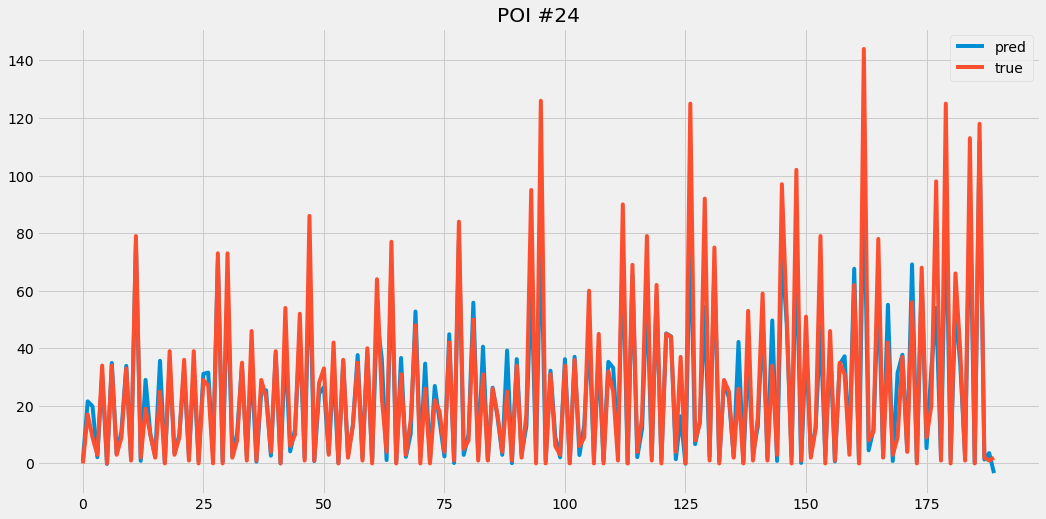

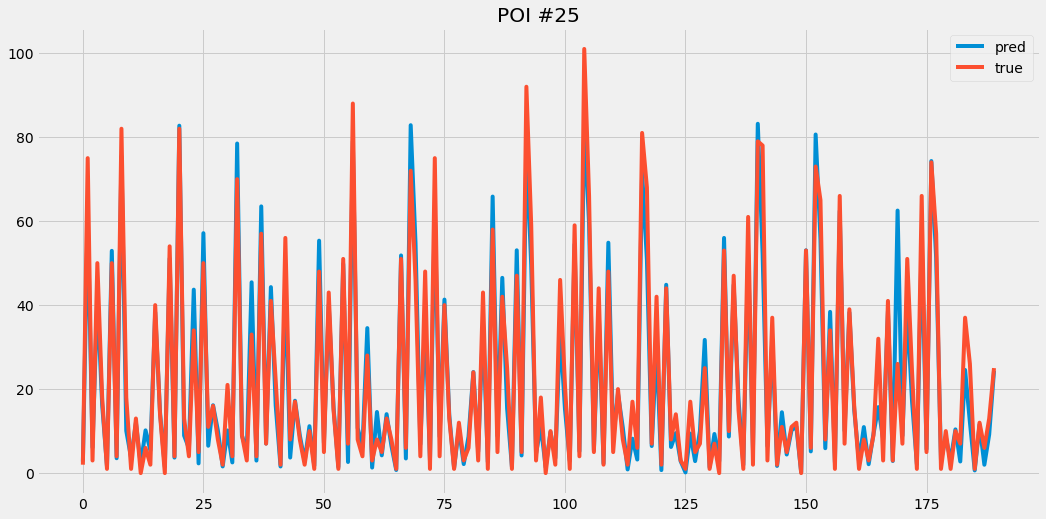

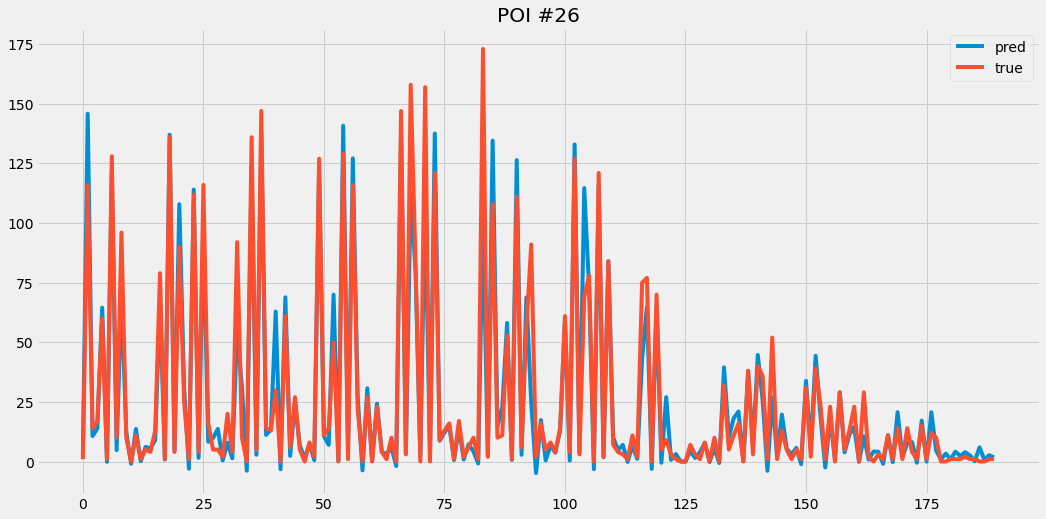

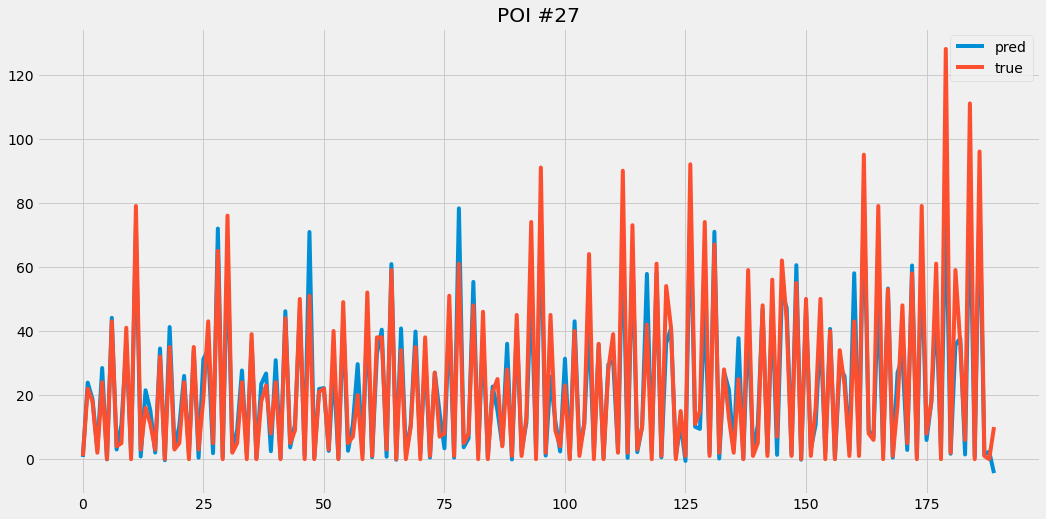

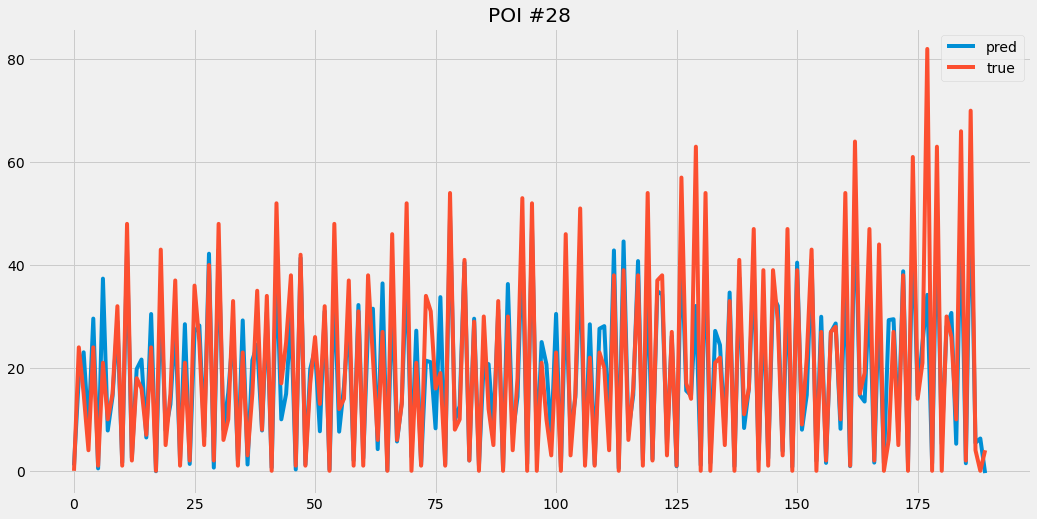

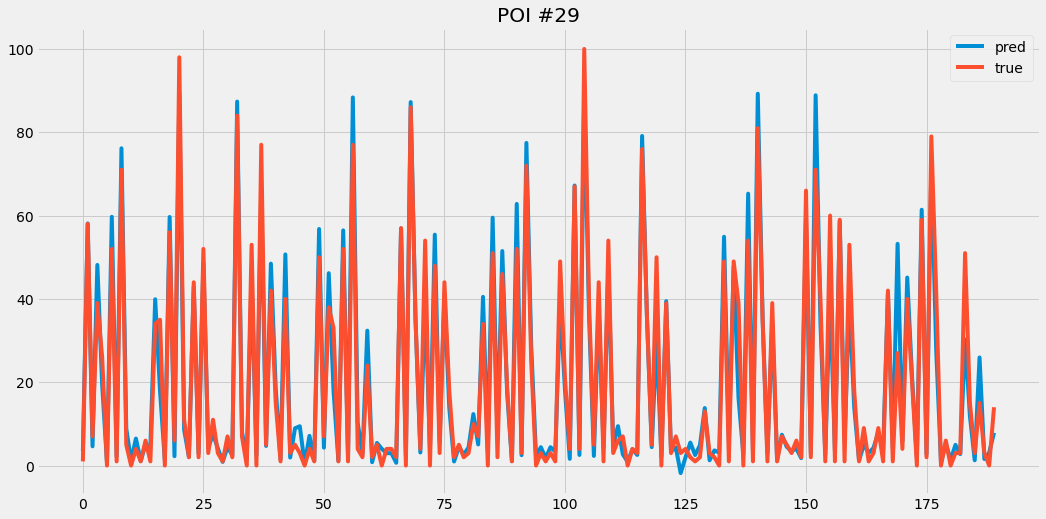

In [20]:
POI_NUM = 0
for i in range(30):
    fig, ax = plt.subplots(figsize=(16, 8))
    plt.title(f'POI #{POI_NUM}')
    plt.plot(preds_data[::10, POI_NUM], label='pred')
    plt.plot(target_data[::10, POI_NUM], label='true')
    plt.legend()
    POI_NUM += 1
    # time.sleep(1)

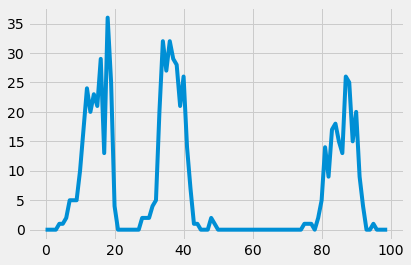

In [21]:
plt.plot(np.array(data_frame.iloc[70].visits_by_each_hour[:100]))

In [ ]:

pred_saved_path = '/home/users/haowenli/POI_pattern/code/exp/Houston/Houston_12-2/RNN/04210204/predictions.npz'
data = np.load(pred_saved_path)
train_pred = data['prediction']
train_truth = data['truth']
x_input = data['input']










num_test = round(total_days * 0.2)
num_train = round(total_days * 0.7)
num_val = total_days - num_test - num_train







time_span = pd.date_range('2019-12-02', '2020-06-09 00:00:00', freq='1D', closed='left').to_series()
cur_time = time_span.iloc[-num_test:]
pred_test_time= cur_time.dt.strftime('%m-%d').to_list()
print(len(cur_time))
#string_data =cur_time.strptime('%Y-%m-%d')
#x
#string_data = [x.strptime('%Y-%m-%d') for x in cur_time]

In [ ]:
train_pred[0]

In [ ]:
all_day_mae, all_day_rmse = eval_by_day(train_pred,train_truth,num_series =2000,days=33)
plot_by_day(all_day_mae, all_day_rmse,pred_test_time[1:])

In [ ]:
all_poi_mae, all_poi_rmse = eval_by_poi(train_pred,train_truth,num_series=2000,days=33)
merge_df['mae'] = all_poi_mae
merge_df['rmse'] =all_poi_rmse
#merge_df = merge_df.sort_values(by=['mae'], ascending=False)

In [ ]:
plot_by_poi_id(all_poi_mae, all_poi_rmse)

In [ ]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', None): 
    display(merge_df)

In [ ]:
def plot_by_poi_map(merge_df):
    plt.figure(figsize=(16, 10))
    colors = np.where(merge_df["mae"]>=3,'r','g')
    plt.scatter(merge_df.latitude, merge_df.longitude, s=3, c=colors)
    #plt.colorbar()

    #plt.clim(0, clip_val)
plot_by_poi_map(merge_df)

In [ ]:
raw_gps_df = merge_df.copy()

print(raw_gps_df.shape)
lower_lat ,upper_lat , lower_long,upper_long = 29.70,29.75,-95.45,-95.35
mae= 3
raw_gps_df= raw_gps_df[raw_gps_df['latitude']>=lower_lat]
raw_gps_df = raw_gps_df[raw_gps_df['latitude']<=upper_lat]
raw_gps_df = raw_gps_df[raw_gps_df['longitude']>=lower_long]
raw_gps_df = raw_gps_df[raw_gps_df['longitude']<=upper_long]
raw_gps_df = raw_gps_df[raw_gps_df['mae']>=mae]

In [ ]:
raw_gps_df.shape
plt.scatter(raw_gps_df.latitude, raw_gps_df.longitude, s=3)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(raw_gps_df)
    

In [ ]:
safegraph_id_list = ['sg:483a114df4b04b10a17f16ff78fe5642','sg:a2bb780279f1448a988e7d597069ed74']
raw_gps_df =merge_df[merge_df['safegraph_place_id'].isin(safegraph_id_list)]
t1 = raw_gps_df.loc[raw_gps_df.index[0], 'visits_by_each_hour']
t2 = raw_gps_df.loc[raw_gps_df.index[1], 'visits_by_each_hour']
plt.plot(t1[-2*24:])
plt.plot(t2[-2*24:])
#plot_by_day(t1[-2*24:],t2[-2*24:],pred_test_time) 

In [ ]:
time_span = pd.date_range('2020-06-06', '2020-06-08 00:00:00', freq='1H', closed='left').to_series()
pred_test_time= time_span.dt.strftime('%m-%d-%h').to_list()
print(len(pred_test_time))
print(len(t1[-2*24:]))